## Homework #5. Exploratory Data Analysis. Behaviour exploration improvement.
#### Author: `Sofiia Kononovych`
#### Total time spent on h/w (in minutes): `1520`

In this homework, I am going to explore the dataset of telegram messages collected by me.

My purpose is to explore behavioual patterns of me and other people judging on their messages sent.





###0. Load and explore the data for analysis

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import json
import seaborn as sns

In [ ]:
# To prevent memory issues this notebook was inplemented in Google Colab, so the paths to the files is according, for testing change it to your values.
DIALOGS_MERGED_DATA_PATH = "/content/drive/MyDrive/tg-dataset-analysis/data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "/content/drive/MyDrive/tg-dataset-analysis/data/merged_data/dialogs_users_fixed.csv"
users_data_path = "/content/drive/MyDrive/tg-dataset-analysis/data/merged_data/parsed_users.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)
df_users = pd.read_csv(users_data_path)

<ipython-input-151-6cb12131976e>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)


In [ ]:
print(df[['dialog_id']].dtypes)
print(df_meta[['dialog_id']].dtypes)

dialog_id    int64
dtype: object
dialog_id    int64
dtype: object


In [ ]:
df['from_id'] = pd.to_numeric(df['from_id'], errors='coerce').fillna(-1).astype('int64')
df['from_id'] = df['from_id'].replace(-1, pd.NA)

In [ ]:
print(df.shape)
print(df[['from_id', 'to_id']].dtypes)
print(df_meta[['dialog_id']].dtypes)
df.head()

(1187414, 10)
from_id    object
to_id       int64
dtype: object
dialog_id    int64
dtype: object


,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id
0,3807.0,2024-10-24 12:27:52+00:00,<NA>,1073261085,NaN,🎙Радіодиктант національної єдності \n\n25.10.2...,photo,NaN,NaN,-1001073261085
1,3806.0,2024-10-24 09:59:58+00:00,<NA>,1073261085,NaN,"🎃 Могилянська історія жахів\n\n26.10.24 (сб), ...",photo,NaN,NaN,-1001073261085
2,3805.0,2024-10-24 07:01:47+00:00,<NA>,1073261085,NaN,"🌌 «Пітьма щедра, і терпляча, і завжди перемага...",photo,NaN,NaN,-1001073261085
3,3804.0,2024-10-24 05:58:02+00:00,<NA>,1073261085,NaN,🕯 Загальнонаціональна хвилина мовчання за заги...,text,NaN,NaN,-1001073261085
4,3803.0,2024-10-23 15:02:01+00:00,<NA>,1073261085,NaN,🕵️‍♂️ Обговорення книги Жоеля Діккера «Правда ...,photo,NaN,NaN,-1001073261085


In [ ]:
df_meta = df_meta.rename(columns={'name': 'dialog_name', 'type': 'dialog_type'})
print(df_meta.shape)
df_meta.head()

(9724, 4)


,dialog_id,dialog_name,dialog_type,users
0,784559684,Софія,Private dialog,"{'user_id': 784559684, 'first_name': 'Софія', ..."
1,-1002177129535,HODIMO | All-Hands,Group,"{'user_id': 694910103, 'first_name': 'katia', ..."
2,-1002177129535,HODIMO | All-Hands,Group,"{'user_id': 398467023, 'first_name': 'Vita', '..."
3,-1002177129535,HODIMO | All-Hands,Group,"{'user_id': 1177662088, 'first_name': 'Anastas..."
4,-1002177129535,HODIMO | All-Hands,Group,"{'user_id': 388864150, 'first_name': 'Саша', '..."


In [ ]:
# Count unique dialog_id in df
unique_dialog_id_dialog_df = df['dialog_id'].nunique()
print("Unique dialog_id in df:", unique_dialog_id_dialog_df)

# Count unique dialog_id in df_meta
unique_dialog_id_meta_df = df_meta['dialog_id'].nunique()
print("Unique dialog_id in df_meta:", unique_dialog_id_meta_df)


Unique dialog_id in df: 632
Unique dialog_id in df_meta: 641


Some messages in df could be missing as there is an inconsistency in ids, but I suppose it could happen during the data extraction. Nevertheless, The number is too small to concentate attention .

I have also parsed df_meta to extract user records, but I do not want to pass algorithm here as there will be too much information in report, but I can show it any time.

In [ ]:
df_users.head()

,user_id,first_name,last_name,username,phone
0,784559684,Софія,NaN,sofiakononovych,3.809990e+11
1,694910103,katia,NaN,mandryk_katia,3.809926e+11
2,398467023,Vita,NaN,vitalinashv,3.806740e+11
3,1177662088,Anastasiia Khlan’,NaN,arrriiiwww,NaN
4,388864150,Саша,Новікова,sashes21,NaN


In [ ]:
df_users.shape
unique_users = df_users['user_id'].nunique()

print(unique_users)

6650


###1. Merge the dialogs data and messages data datasets.
Merged Dataframe will contain such columns:
- id
- date
- from_id
- to_id
- fwd_from
- message
- type
- duartion
- reactios
- Dialog_id
- dialog_type
- dialog_name
- day_of_week

Separate users_df that contains all users data:
- user_id
- first_name
- last_name
- username
- phone


In [ ]:
# Let`s clean df_meta first : remove user_id (we do not need it now) and remove duplicate rows

df_meta_cleaned = df_meta.drop(columns=['users'])
df_meta_cleaned = df_meta_cleaned.drop_duplicates()
df_meta_cleaned = df_meta_cleaned.reset_index(drop=True)

print(len(df_meta_cleaned))
df_meta_cleaned.head()

641


,dialog_id,dialog_name,dialog_type
0,784559684,Софія,Private dialog
1,-1002177129535,HODIMO | All-Hands,Group
2,-1002329265739,English Eva,Channel
3,-1001671254477,МАТЕМАТИКОПРИКЛАДСТВО,Group
4,538404477,Квартирант - Київ 🇺🇦 | X-Estate,Private dialog


In [ ]:
df_merged = df.merge(df_meta_cleaned, on='dialog_id', how='inner')
print(df_merged.shape)
df_merged.head()

(1187414, 12)


,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type
0,3807.0,2024-10-24 12:27:52+00:00,<NA>,1073261085,NaN,🎙Радіодиктант національної єдності \n\n25.10.2...,photo,NaN,NaN,-1001073261085,KMA Today,Channel
1,3806.0,2024-10-24 09:59:58+00:00,<NA>,1073261085,NaN,"🎃 Могилянська історія жахів\n\n26.10.24 (сб), ...",photo,NaN,NaN,-1001073261085,KMA Today,Channel
2,3805.0,2024-10-24 07:01:47+00:00,<NA>,1073261085,NaN,"🌌 «Пітьма щедра, і терпляча, і завжди перемага...",photo,NaN,NaN,-1001073261085,KMA Today,Channel
3,3804.0,2024-10-24 05:58:02+00:00,<NA>,1073261085,NaN,🕯 Загальнонаціональна хвилина мовчання за заги...,text,NaN,NaN,-1001073261085,KMA Today,Channel
4,3803.0,2024-10-23 15:02:01+00:00,<NA>,1073261085,NaN,🕵️‍♂️ Обговорення книги Жоеля Діккера «Правда ...,photo,NaN,NaN,-1001073261085,KMA Today,Channel


The last preprocessing step is to change Nan values for received messages from private chats into the value of dialog_id

In [ ]:
# Set value of my tg id
my_userid = '@sofiakononovych'
my_id = 784559684

In [ ]:
received_private = df_merged[
    (df_merged['dialog_type'] == 'Private dialog') &
    (df_merged['from_id'] != my_id) &
    (df_merged['to_id'] == my_id)
]
# update 'from_id' for private dialog messages where it is missing
df.loc[
    (df_merged['dialog_type'] == 'Private dialog') & (df_merged['to_id'] == my_id) &
    (df_merged['from_id'].isna()),
    'from_id'
] = df_merged['dialog_id']

In [ ]:
df_merged[(df_merged['from_id'] == 303234186)][:10]

,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type
1001752,18.0,2024-10-15 09:56:46+00:00,303234186,2350601955,NaN,NaN,text,NaN,{},-1002350601955,RAI for Ukraine (2024-2025),Group
1057131,218021.0,2024-10-25 19:27:05+00:00,303234186,4544444951,NaN,Сторінкою нижче є промпт і жовтим виділено мої...,text,NaN,{},-4544444951,RAI vrt-chat,Group
1057132,218020.0,2024-10-25 19:26:49+00:00,303234186,4544444951,NaN,https://docs.google.com/document/d/1ccswvNs8Zt...,photo,NaN,{1087609597: <telethon.tl.types.ReactionEmoji ...,-4544444951,RAI vrt-chat,Group
1057161,215462.0,2024-10-17 19:20:19+00:00,303234186,4544444951,NaN,Nope,text,NaN,{},-4544444951,RAI vrt-chat,Group
1057172,215269.0,2024-10-17 05:39:12+00:00,303234186,4544444951,NaN,"І він питає в чаті, чи могли б наступного тижн...",text,NaN,{},-4544444951,RAI vrt-chat,Group
1057173,215268.0,2024-10-17 05:37:29+00:00,303234186,4544444951,NaN,https://docs.google.com/presentation/u/0/d/1ea...,photo,NaN,{},-4544444951,RAI vrt-chat,Group
1057175,215211.0,2024-10-16 20:03:47+00:00,303234186,4544444951,NaN,Привіт! Там є на слайдах цієї презентації. Ну ...,text,NaN,{784559684: <telethon.tl.types.ReactionEmoji o...,-4544444951,RAI vrt-chat,Group
1057188,213649.0,2024-10-10 10:55:56+00:00,303234186,4544444951,NaN,Добре,text,NaN,{},-4544444951,RAI vrt-chat,Group
1057190,213647.0,2024-10-10 10:55:21+00:00,303234186,4544444951,NaN,І його і буду,text,NaN,{},-4544444951,RAI vrt-chat,Group
1057191,213646.0,2024-10-10 10:55:13+00:00,303234186,4544444951,NaN,Я читав ViewCrafter,text,NaN,{},-4544444951,RAI vrt-chat,Group


Our datasets are ready, so let`s move to EDA.

###2. Basic Dataset Overview and Statistics
Let's display some more basic info about the datasets and explore statistics.

In [ ]:
colors = ['#8C7AA9','#7192BE', '#EDA2F2', '#0E0E52', 'skyblue']

***Q1. What is the distribution of message types throughout all messages and what is the distribution of chat types across all chats? ***

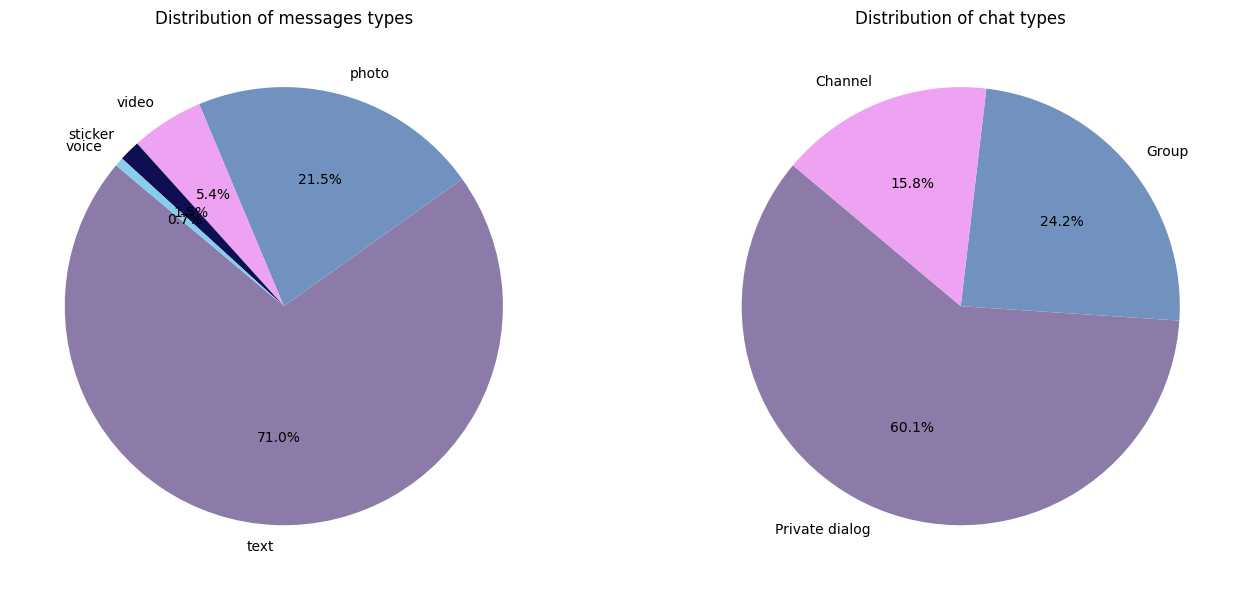

In [ ]:
# Distribution by message_type
message_counts = df_merged['type'].value_counts()

# Display number of chats for each type (private, group, channel etc)
chat_counts = df_meta_cleaned['dialog_type'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    message_counts,
    labels=message_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors[:len(message_counts)]
)
axes[0].set_title('Distribution of messages types')

axes[1].pie(
    chat_counts,
    labels=chat_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors[:len(chat_counts)]
)
axes[1].set_title('Distribution of chat types')

plt.tight_layout()
plt.show()

**Q2. What is the distribution of all messages by dialog_type? **






In [ ]:
# Display number of messages by different dialog types
private_messages = df_merged[df_merged['dialog_type'] == 'Private dialog']

group_messages = df_merged[df_merged['dialog_type'] == 'Group']

channel_messages = df_merged[df_merged['dialog_type'] == 'Channel']

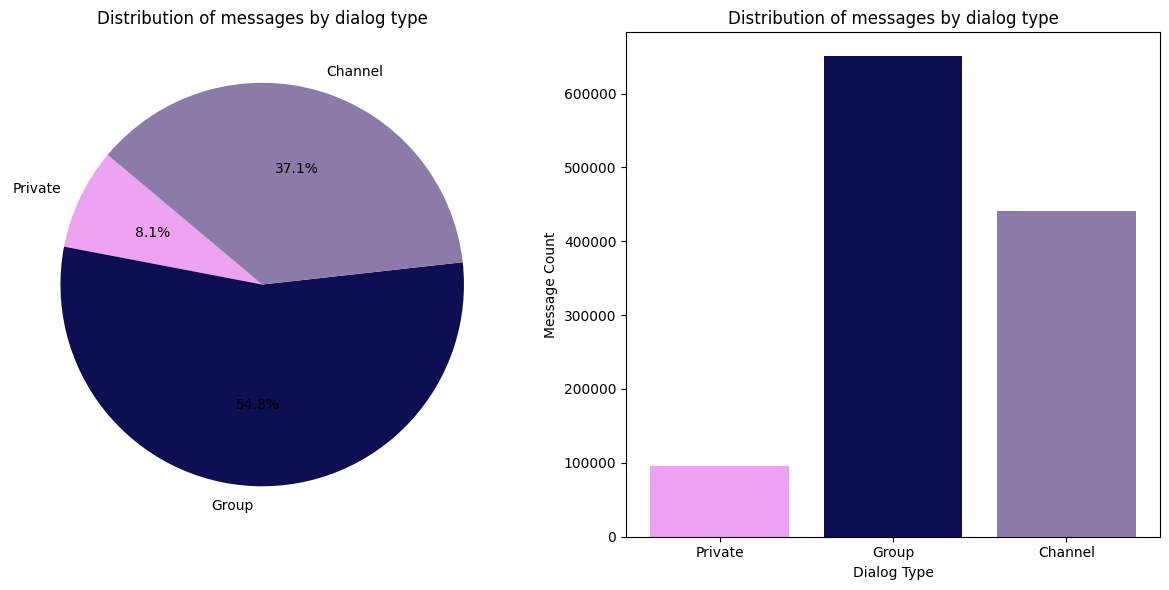

In [ ]:
# Calculate counts for each dialog type
message_counts = {
    'Private': len(private_messages),
    'Group': len(group_messages),
    'Channel': len(channel_messages)
}

# Convert counts to a DataFrame for visualization
message_counts_df = pd.DataFrame(list(message_counts.items()), columns=['Dialog Type', 'Message Count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(
    message_counts.values(),
    labels=message_counts.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#EDA2F2', '#0E0E52', '#8C7AA9']
)
ax1.set_title('Distribution of messages by dialog type')

ax2.bar(message_counts.keys(), message_counts.values(), color=['#EDA2F2', '#0E0E52', '#8C7AA9'])
ax2.set_title('Distribution of messages by dialog type')
ax2.set_xlabel('Dialog Type')
ax2.set_ylabel('Message Count')

plt.tight_layout()
plt.show()

***Q3. What is my communacation in diffrent chats?***

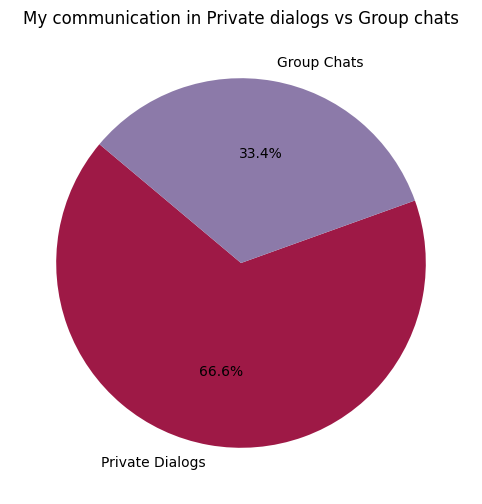

In [ ]:
# My communacation in private dialogs vs group chats
sent_by_me_private = df_merged[
    (df_merged['from_id'] == my_id) & (df_merged['dialog_type'] == 'Private dialog')].shape[0]

sent_by_me_group = df_merged[
    (df_merged['from_id'] == my_id) & (df_merged['dialog_type'] == 'Group')].shape[0]

data = [sent_by_me_private, sent_by_me_group]
labels = ['Private Dialogs', 'Group Chats']
colors = ['#9E1946', '#8C7AA9']

plt.figure(figsize=(8, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("My communication in Private dialogs vs Group chats")
plt.show()

###3. Analysis of data by time
In this section I explore time charachteristics of my data and try to extract all the valuable insight from it

In [ ]:
df_merged['date'] = pd.to_datetime(df_merged['date'])
# Adjust to timezone in Ukraine
df_merged['date'] = df_merged['date'] + pd.Timedelta(hours=2)

First explore all messages (sent and recieved)

In [ ]:
# Plot number of messages (send and recieved) over time (monthly)
monthly_counts = df_merged.resample('M', on='date').size()

# Distribution of activity by the time of the day
df_merged['hour'] = df_merged['date'].dt.hour
hourly_activity = df_merged['hour'].value_counts().sort_index()

# Distribution of activity by day of the week
df_merged['day_of_week'] = df_merged['date'].dt.dayofweek
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
           4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_merged['day_of_week'] = df_merged['day_of_week'].map(day_map)
weekly_activity = df_merged['day_of_week'].value_counts().reindex(day_map.values())


<ipython-input-170-f4e79cab8d47>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df_merged.resample('M', on='date').size()


***Q4.***

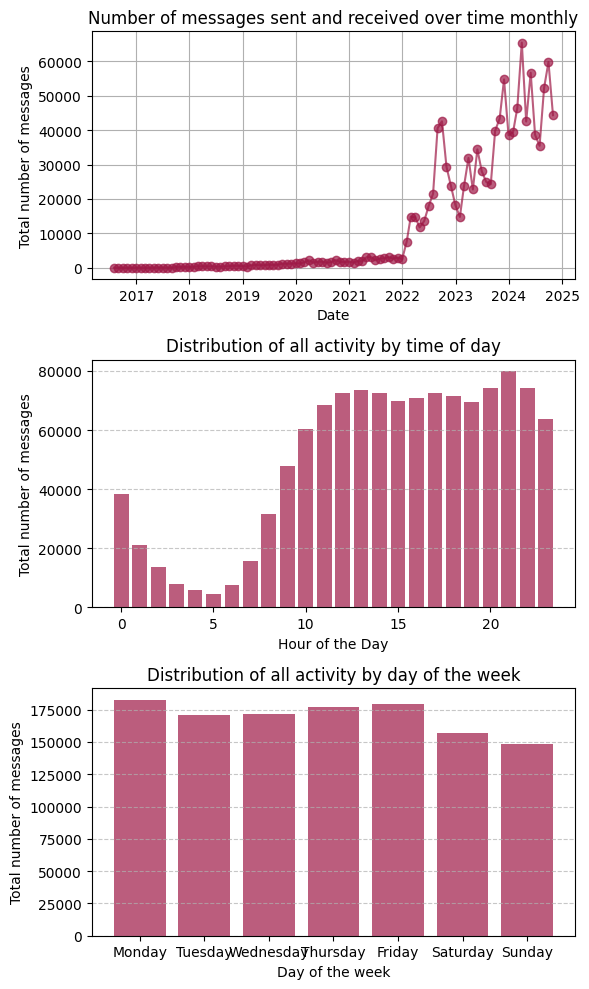

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].plot(monthly_counts.index, monthly_counts.values, color='#9E1946', marker='o', alpha=0.7)
axs[0].set_title('Number of messages sent and received over time monthly')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Total number of messages')
axs[0].grid(True)

axs[1].bar(hourly_activity.index, hourly_activity.values, color='#9E1946', alpha=0.7)
axs[1].set_title('Distribution of all activity by time of day')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Total number of messages')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

axs[2].bar(weekly_activity.index, weekly_activity.values, color='#9E1946', alpha=0.7)
axs[2].set_title('Distribution of all activity by day of the week')
axs[2].set_xlabel('Day of the week')
axs[2].set_ylabel('Total number of messages')
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Next explore only messages sent by me to find patterns in behaviour

In [ ]:
df_sent_by_me = df_merged[df_merged['from_id'] == my_id]
df_sent_by_me.head()

,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type,hour,day_of_week
32437,369183.0,2024-10-01 13:19:48+00:00,784559684,1142723513,NaN,"блін сорі, перебила твій потік думок😭",text,NaN,{},-1001142723513,ФІ,Group,13,Tuesday
32439,369181.0,2024-10-01 13:19:11+00:00,784559684,1142723513,NaN,⚡️Шукаємо розробника!\n\n- Компанія: HODIMO AP...,text,NaN,{509580698: <telethon.tl.types.ReactionEmoji o...,-1001142723513,ФІ,Group,13,Tuesday
113371,287260.0,2024-03-11 16:12:03+00:00,784559684,1142723513,NaN,Усім привіт! Команда могилянців зараз активно ...,text,NaN,NaN,-1001142723513,ФІ,Group,16,Monday
149363,311236.0,2022-09-11 23:19:23+00:00,784559684,1209215640,NaN,"ого, оце ділові пропозиції вже пішли пххппх",text,NaN,{705751024: <telethon.tl.types.ReactionEmoji o...,-1001209215640,чат абітури 🔪,Group,23,Sunday
149370,311228.0,2022-09-11 23:16:45+00:00,784559684,1209215640,NaN,"я твій тисячний підписник:) до речі, у тебе ду...",text,NaN,{},-1001209215640,чат абітури 🔪,Group,23,Sunday


***Q5.***

<ipython-input-173-faf86a2e0378>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df_sent_by_me.resample('M', on='date').size()
<ipython-input-173-faf86a2e0378>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent_by_me['hour'] = df_sent_by_me['date'].dt.hour
<ipython-input-173-faf86a2e0378>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent_by_me['day_of_week'] = df_sent_by_me['date'].dt.dayofweek
<ipython-input-173-faf86a2

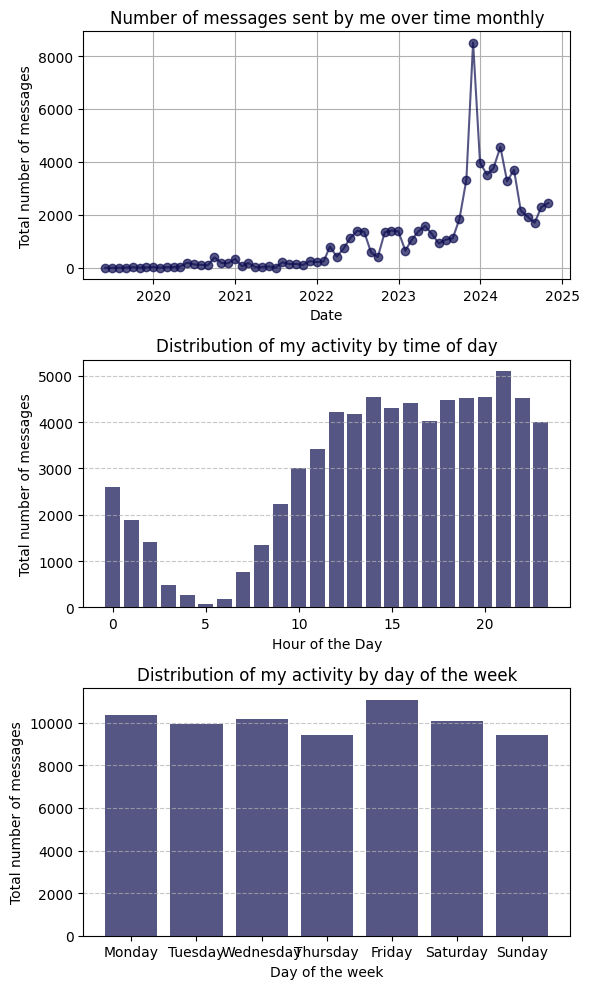

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

monthly_counts = df_sent_by_me.resample('M', on='date').size()
axs[0].plot(monthly_counts.index, monthly_counts.values, color='#0E0E52', marker='o', alpha=0.7)
axs[0].set_title('Number of messages sent by me over time monthly')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Total number of messages')
axs[0].grid(True)

df_sent_by_me['hour'] = df_sent_by_me['date'].dt.hour
hourly_activity = df_sent_by_me['hour'].value_counts().sort_index()
axs[1].bar(hourly_activity.index, hourly_activity.values, color='#0E0E52', alpha=0.7)
axs[1].set_title('Distribution of my activity by time of day')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Total number of messages')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

df_sent_by_me['day_of_week'] = df_sent_by_me['date'].dt.dayofweek
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_sent_by_me['day_of_week'] = df_sent_by_me['day_of_week'].map(day_map)
weekly_activity = df_sent_by_me['day_of_week'].value_counts().reindex(day_map.values())
axs[2].bar(weekly_activity.index, weekly_activity.values, color='#0E0E52', alpha=0.7)
axs[2].set_title('Distribution of my activity by day of the week')
axs[2].set_xlabel('Day of the week')
axs[2].set_ylabel('Total number of messages')
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Tendency in my sleeping hours.
Sleeping hours here are estimated between my last sent message between 22:00-4:00 and first sent message between 6:00 - 11:00

In [ ]:
sleep_data = []

for day, messages in df_sent_by_me.groupby(df_sent_by_me['date'].dt.date):
    # Find the last message sent between 22:00-4:00 (go to sleep time)
    night_messages = messages[(messages['hour'] >= 22) | (messages['hour'] < 4)]
    if not night_messages.empty:
        last_night_message = night_messages['date'].max()
    else:
        continue

    # Find the first message sent between 6:00-11:00 (awake time)
    morning_messages = messages[(messages['hour'] >= 6) & (messages['hour'] < 11)]
    if not morning_messages.empty:
        first_morning_message = morning_messages['date'].min()
    else:
        continue

    # Ensure the first morning message is after the last evening message
    if first_morning_message > last_night_message:
        sleep_duration = (first_morning_message - last_night_message).total_seconds() / 3600
        sleep_data.append({'date': day,
                           'day_of_week': last_night_message.dayofweek,
                           'sleep_duration': sleep_duration})

df_sleep = pd.DataFrame(sleep_data)

df_sleep.head(10)

,date,day_of_week,sleep_duration
0,2022-07-16,5,2.871111
1,2022-07-31,6,9.555833
2,2022-10-03,0,8.052222
3,2022-10-11,1,8.665000
4,2022-10-16,6,10.001389
5,2022-11-07,0,7.736389
6,2022-12-15,3,7.999167
7,2022-12-17,5,10.555000
8,2022-12-28,2,9.738333
9,2022-12-29,3,7.733333


**Q6. How much do I sleep judging from my tg activity?**

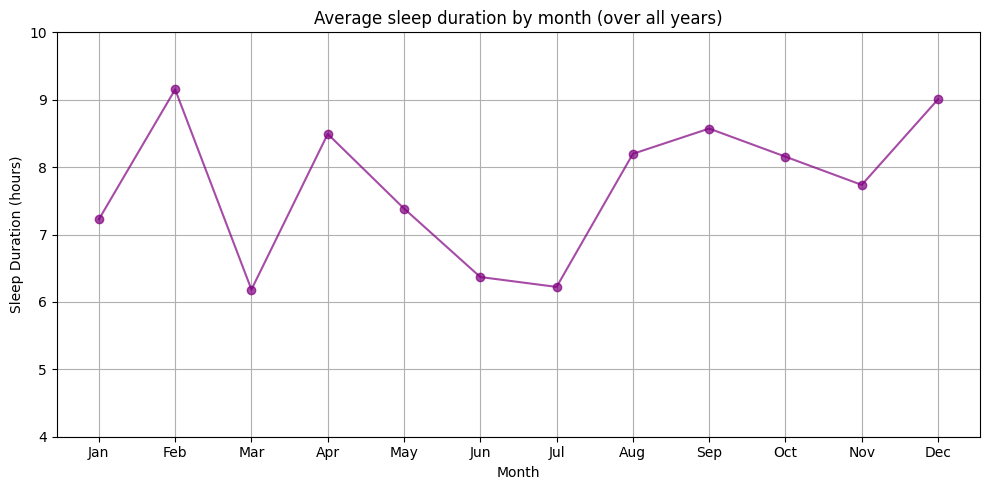

In [ ]:
# Plot the sleep duration over time
df_sleep['date'] = pd.to_datetime(df_sleep['date'])

df_sleep['month'] = df_sleep['date'].dt.month

df_monthly_sleep = df_sleep.groupby('month')['sleep_duration'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly_sleep['month'], df_monthly_sleep['sleep_duration'], marker='o', color='purple', linestyle='-', alpha=0.7)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(4, 10)
plt.title('Average sleep duration by month (over all years)')
plt.xlabel('Month')
plt.ylabel('Sleep Duration (hours)')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-176-50d081c7a7e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_2['week'] = df_last_2['date'].dt.to_period('W').apply(lambda r: r.start_time)


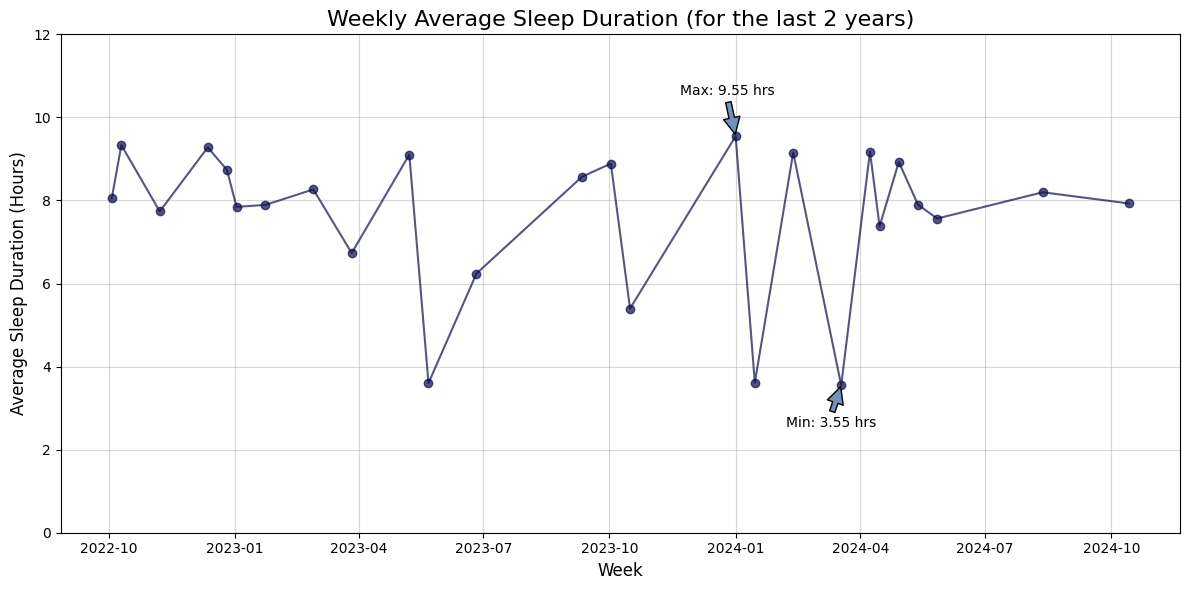

In [ ]:
df_last_2 = df_sleep[df_sleep['date'] >= '2022-09-01']

df_last_2['week'] = df_last_2['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate weekly average sleep duration
df_weekly_sleep = df_last_2.groupby('week')['sleep_duration'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_weekly_sleep['week'], df_weekly_sleep['sleep_duration'], marker='o', linestyle='-', alpha=0.7, color = '#0E0E52')

# Highlight the min and max points
min_index = df_weekly_sleep['sleep_duration'].idxmin()
max_index = df_weekly_sleep['sleep_duration'].idxmax()

plt.annotate(f"Min: {df_weekly_sleep.loc[min_index, 'sleep_duration']:.2f} hrs",
             xy=(df_weekly_sleep.loc[min_index, 'week'], df_weekly_sleep.loc[min_index, 'sleep_duration']),
             xytext=(-40, -30), textcoords='offset points',
             arrowprops=dict(facecolor='#7192BE', shrink=0.05),
             fontsize=10, color='black')

plt.annotate(f"Max: {df_weekly_sleep.loc[max_index, 'sleep_duration']:.2f} hrs",
             xy=(df_weekly_sleep.loc[max_index, 'week'], df_weekly_sleep.loc[max_index, 'sleep_duration']),
             xytext=(-40, 30), textcoords='offset points',
             arrowprops=dict(facecolor='#7192BE', shrink=0.05),
             fontsize=10, color='black')

plt.title('Weekly Average Sleep Duration (for the last 2 years)', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Sleep Duration (Hours)', fontsize=12)
plt.ylim(0, 12)
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()


The plots show the distribution of my 'supposed' sleep by month and week, judging from my activity in telegram.

Lets evaluate results and think of possible error rate.
- From the first plot we see Jun has the average least amount of sleep - it is summer, lots of parties, night texting. March has the lowest rate, approximately 6 hrs - maybe it is explained by large amount of studying. The same tendency in November - lots of studying as well. The largest amount of sleep is in February - the time of winter holidays.

- The second plot that is my sleep for the years of studying in uni and the tendency in sleep during exams is becoming lower (expectable), sping exams (April-May) tend to be more harsh than autumn exams judging from sleeping data. Also min number of sleeping hours (3.55) was indeed when I was having exams at two universities at the same time.

So, results are pretty precise and align with truth.

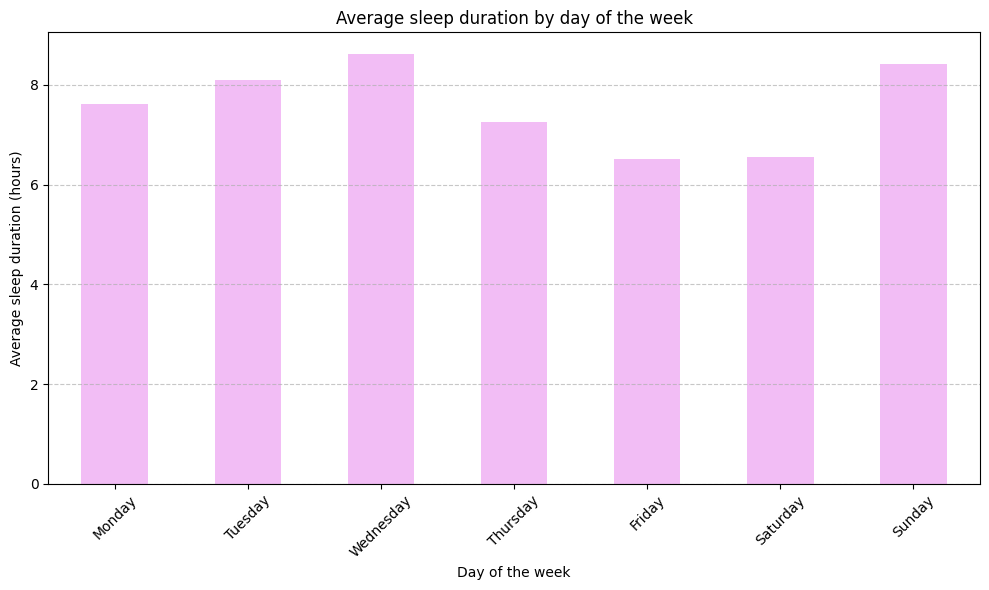

In [ ]:
df_sleep['day_of_week'] = df_sleep['day_of_week'].map(day_map)

# Calculate average sleep duration by day of the week
average_sleep_by_day = df_sleep.groupby('day_of_week')['sleep_duration'].mean().reindex(day_map.values())

# Plot the average sleep duration by day of the week
plt.figure(figsize=(10, 6))
average_sleep_by_day.plot(kind='bar', color='#EDA2F2', alpha=0.7)
plt.title('Average sleep duration by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average sleep duration (hours)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

It looks like more or less true distribution judging from my sleeping habits.

#### Q7. The average private conversation vs group conversation duration observed

- Let's consider that conversation is 2+ messages
- Let's consider that new conversation starts if it passed more than 15 min after last sent message

In [ ]:
def calc_avg_convo_dur(messages):
    # important : sort lconversation by dialog_id and time
    messages['date'] = pd.to_datetime(messages['date'], errors='coerce')
    messages = messages.dropna(subset=['date'])

    messages = messages.sort_values(by=['dialog_id', 'date'])

    # time passed between 2 messages
    messages['time_diff'] = messages.groupby('dialog_id')['date'].diff()

    # define if new conversation (time difference > 15 minutes) and for the first message (has NaN time_diff) is treated as True
    messages['new_convo'] = (messages['time_diff'] > pd.Timedelta(minutes=15)).fillna(True)

    # now lets create column with conversations where new_convo = True inticates the new conversation
    messages['convo_id'] = (
        messages.groupby('dialog_id')['new_convo'].cumsum()
    )

    # print(messages.head(10))

    # group by dialog_id and convо_id, aggregate by time and count and put into new df
    convo_info = messages.groupby(['dialog_id', 'convo_id']).agg(
        start_time=('date', 'min'),
        end_time=('date', 'max'),
        message_count=('id', 'count')
    ).reset_index()

    valid_convos = convo_info[convo_info['message_count'] >= 2]

    valid_convos['duration_min'] = (
        valid_convos['end_time'] - valid_convos['start_time']
    ).dt.total_seconds() / 60

    return valid_convos, valid_convos['duration_min'].mean()

In [ ]:
valid_convos_pr, avg_private_duration = calc_avg_convo_dur(private_messages)
valid_convos_gr, avg_group_duration = calc_avg_convo_dur(group_messages)

valid_convos_gr.head()

<ipython-input-178-113bfc0d8d98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  messages['date'] = pd.to_datetime(messages['date'], errors='coerce')
<ipython-input-178-113bfc0d8d98>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_convos['duration_min'] = (
<ipython-input-178-113bfc0d8d98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,dialog_id,convo_id,start_time,end_time,message_count,duration_min
0,-1002391764203,0,2024-10-07 17:15:24+00:00,2024-10-07 17:39:09+00:00,13,23.750000
1,-1002391764203,1,2024-10-07 18:10:46+00:00,2024-10-07 18:11:04+00:00,2,0.300000
3,-1002391764203,3,2024-10-08 18:48:32+00:00,2024-10-08 19:03:54+00:00,6,15.366667
4,-1002391764203,4,2024-10-08 21:45:58+00:00,2024-10-08 21:46:32+00:00,3,0.566667
5,-1002391764203,5,2024-10-09 16:55:16+00:00,2024-10-09 16:57:37+00:00,4,2.350000


In [ ]:
print(f"Average Private Conversation Duration: {avg_private_duration:.2f} minutes")
print(f"Average Group Conversation Duration: {avg_group_duration:.2f} minutes")

Average Private Conversation Duration: 6.94 minutes
Average Group Conversation Duration: 15.12 minutes


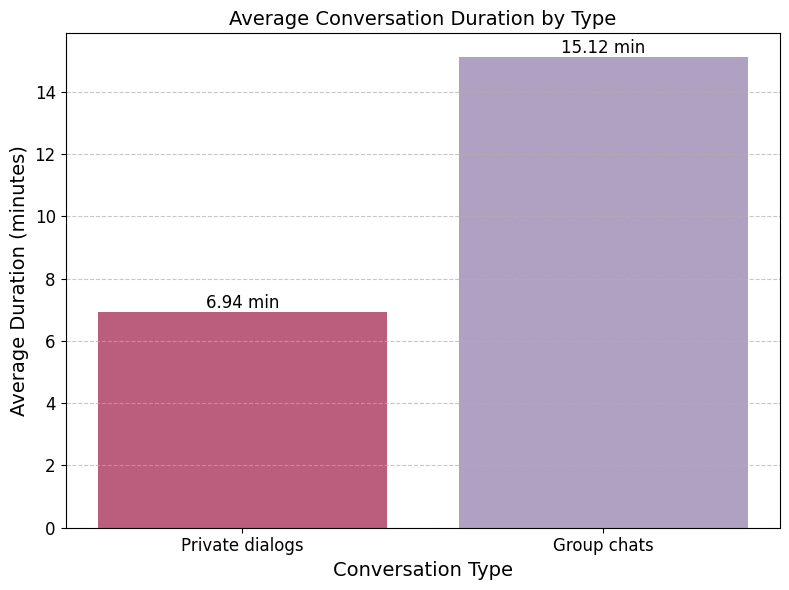

In [ ]:
categories = ['Private dialogs', 'Group chats']
durations = [avg_private_duration, avg_group_duration]
colors = ['#9E1946', '#8C7AA9']

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, durations, color=colors, alpha=0.7)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f} min",
        ha='center', va='bottom', fontsize=12
    )

plt.title('Average Conversation Duration by Type', fontsize=14)
plt.xlabel('Conversation Type', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Results indeed show that conversation in group is longer, however, I expected the difference to be more significant as there are times larger amount of people in group comparing with conversation of 2 people.

So my private conversations are quite long, which is interesting.

<ipython-input-182-dba109a86398>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_convos['dialog_name'] = filtered_convos['dialog_id'].map(dialog_id_to_name)
<ipython-input-182-dba109a86398>:27: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from current font.
  plt.tight_layout()
<ipython-input-182-dba109a86398>:27: UserWarning: Glyph 128133 (\N{NAIL POLISH}) missing from current font.
  plt.tight_layout()
<ipython-input-182-dba109a86398>:27: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  plt.tight_layout()
<ipython-input-182-dba109a86398>:27: UserWarning: Glyph 128001 (\N{MOUSE}) missing from current font.
  plt.tight_layout()
<ipython-input-182-dba109a86398>:27: UserWarning: Gl

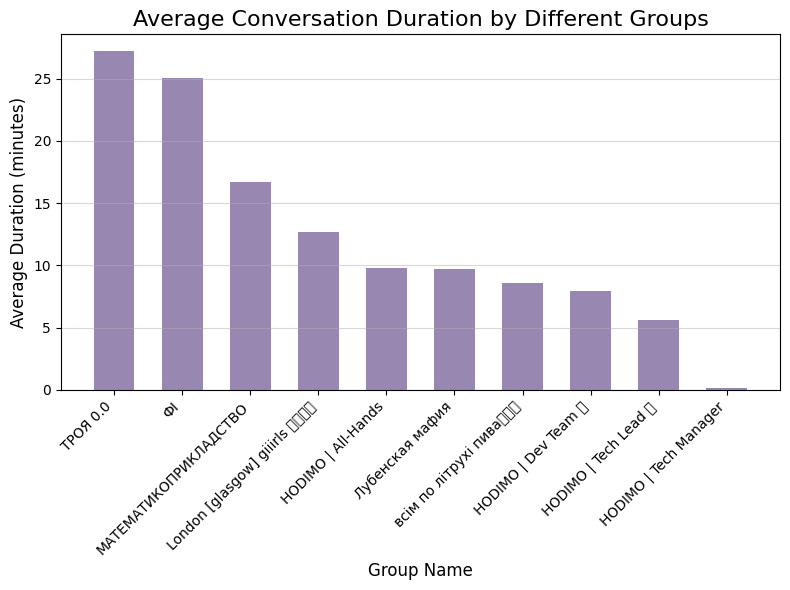

In [ ]:
prefixes = ['ФІ', 'ТРОЯ', 'МАТЕМАТИКО', 'London', 'всім', 'Лубенская', 'HODIMO']
filtered_dialog_ids = df_merged[df_merged['dialog_name'].notna() & df_merged['dialog_name'].str.startswith(tuple(prefixes))][['dialog_id', 'dialog_name']]

filtered_convos = valid_convos_gr[valid_convos_gr['dialog_id'].isin(filtered_dialog_ids['dialog_id'])]

dialog_id_to_name = dict(zip(filtered_dialog_ids['dialog_id'], filtered_dialog_ids['dialog_name']))

filtered_convos['dialog_name'] = filtered_convos['dialog_id'].map(dialog_id_to_name)

group_avg_duration = filtered_convos.groupby('dialog_name')['duration_min'].mean().reset_index()

# Sort the data for better visualization
group_avg_duration = group_avg_duration.sort_values('duration_min', ascending=False)

plt.figure(figsize=(8, 6))
x = np.arange(len(group_avg_duration))
plt.bar(x, group_avg_duration['duration_min'], color='#8C7AA9', alpha=0.9, width=0.6)

plt.xticks(x, group_avg_duration['dialog_name'], rotation=45, ha='right', fontsize=10)

plt.title('Average Conversation Duration by Different Groups', fontsize=16)
plt.xlabel('Group Name', fontsize=12)
plt.ylabel('Average Duration (minutes)', fontsize=12)
plt.grid(axis='y', alpha=0.5)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

As we see  from the plot, the duaration of conversation indeed depends from the size of the gruop, for large groups (ТРОЯ, ФІ, МАТЕМАТИКОПРИКЛАДСТВО) convesation is much longer than for my friends group.

***Q8. How does duration of conversation differs in group chats vs private conversation***

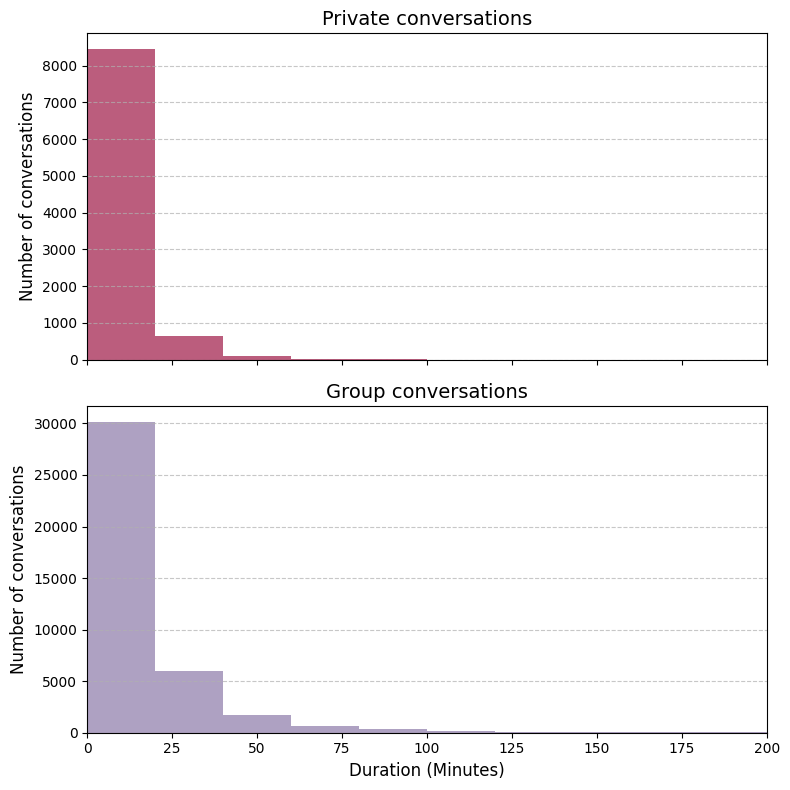

In [ ]:
private_durations = valid_convos_pr['duration_min']
group_durations = valid_convos_gr['duration_min']

bins = np.arange(0, max(private_durations.max(), group_durations.max()) + 20, 20)  # 20-minute intervals

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Private conversations histogram
axes[0].hist(private_durations, bins=bins, color='#9E1946', alpha=0.7)
axes[0].set_title('Private conversations', fontsize=14)
axes[0].set_ylabel('Number of conversations', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xlim(0, 200)

# Group conversations histogram
axes[1].hist(group_durations, bins=bins, color='#8C7AA9', alpha=0.7)
axes[1].set_title('Group conversations', fontsize=14)
axes[1].set_xlabel('Duration (Minutes)', fontsize=12)
axes[1].set_ylabel('Number of conversations', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_xlim(0, 200)

plt.tight_layout()
plt.show()


***Q9. What is the conversation duration in my best friends chat?***

In [ ]:
# Weekly average conversation durations in my friends group chat
df_filt_name = df_merged[df_merged['dialog_name'].notna()]
fr_id = df_filt_name[df_filt_name['dialog_name'].str.startswith('London')]['dialog_id'].iloc[0]
print(fr_id)

-4067191126


Index(['dialog_id', 'convo_id', 'start_time', 'end_time', 'message_count',
       'duration_min'],
      dtype='object')


<ipython-input-185-542913f30fc7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  friend_convos['start_time'] = pd.to_datetime(friend_convos['start_time']).dt.tz_localize(None)
<ipython-input-185-542913f30fc7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  friend_convos['week_start'] = friend_convos['start_time'].dt.to_period('W').apply(lambda x: x.start_time)


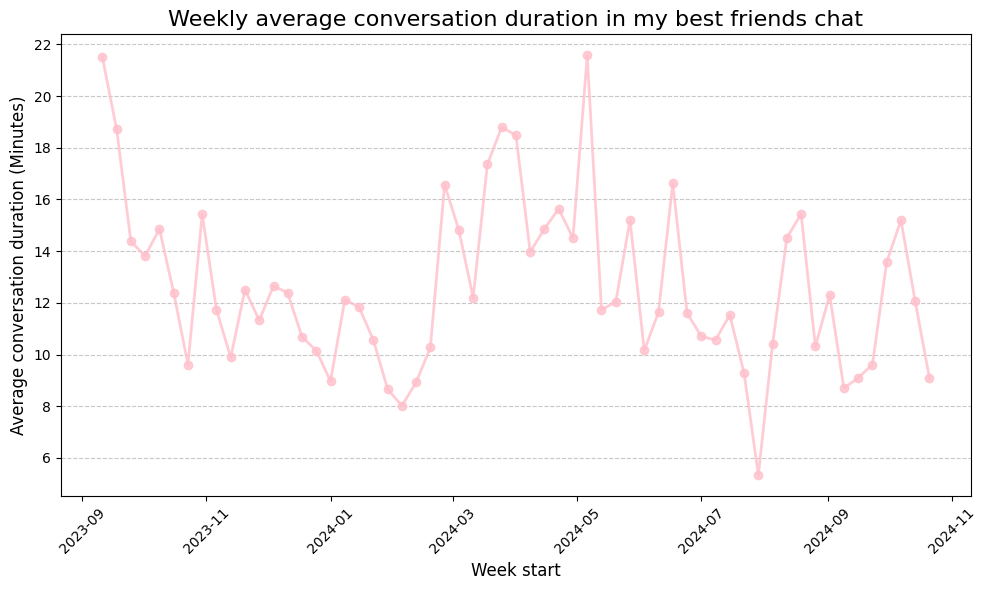

In [ ]:
friend_convos = valid_convos_gr[valid_convos_gr['dialog_id'] == fr_id]
print(friend_convos.columns)

friend_convos['start_time'] = pd.to_datetime(friend_convos['start_time']).dt.tz_localize(None)

# Create 'week_start' by converting to PeriodIndex and back to Timestamps
friend_convos['week_start'] = friend_convos['start_time'].dt.to_period('W').apply(lambda x: x.start_time)
weekly_avg_duration = (
    friend_convos.groupby('week_start')['duration_min'].mean().reset_index()
)

plt.figure(figsize=(10, 6))
plt.plot(
    weekly_avg_duration['week_start'],
    weekly_avg_duration['duration_min'],
    color='pink',
    linewidth=2,
    alpha=0.8,
    marker='o'
)

plt.title('Weekly average conversation duration in my best friends chat', fontsize=16)
plt.xlabel('Week start', fontsize=12)
plt.ylabel('Average conversation duration (Minutes)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

#### Distribution of messages I received on my birthday, New Year/chrismas and Easter vs Average messages received per day

**Q10. Does the number of sent and received messages differs on special dates?**



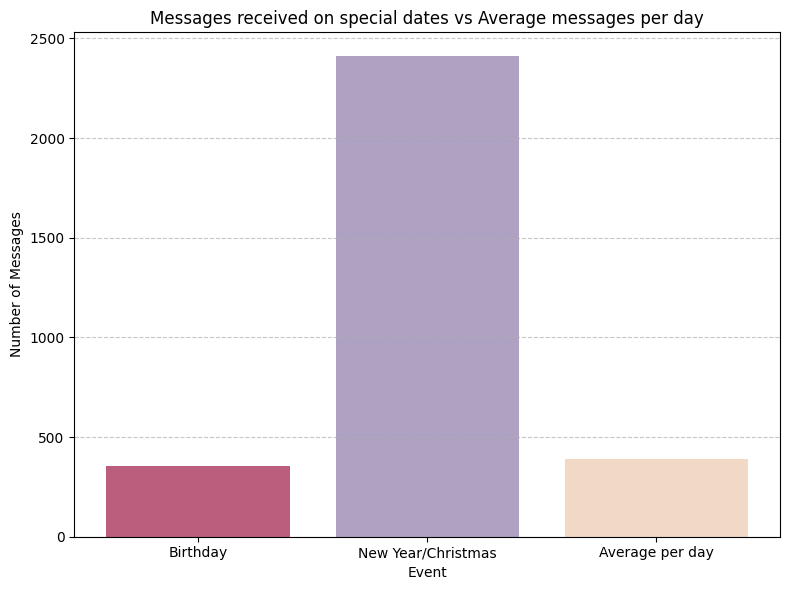

In [ ]:
df_received = df_merged[df_merged['from_id'] != my_id]

average_messages_per_day = len(df_received) / df_received['date'].dt.date.nunique()

birthday_messages = df_received[(df_received['date'].dt.month == 2) & (df_received['date'].dt.day == 11)]
average_birthday_messages = len(birthday_messages) / birthday_messages['date'].dt.year.nunique()

new_year_christmas_messages = df_received[
    ((df_received['date'].dt.month == 12) & (df_received['date'].dt.day >= 24)) |
    ((df_received['date'].dt.month == 1) & (df_received['date'].dt.day <= 7))
]
average_new_year_christmas_messages = len(new_year_christmas_messages) / new_year_christmas_messages['date'].dt.year.nunique()


counts = {
    'Birthday': average_birthday_messages,
    'New Year/Christmas': average_new_year_christmas_messages,
    'Average per day': average_messages_per_day}

plt.figure(figsize=(8, 6))
plt.bar(
    counts.keys(),
    counts.values(),
    color=['#9E1946', '#8C7AA9', '#EDC9AF'],  # Color palette
    alpha=0.7
)
plt.title('Messages received on special dates vs Average messages per day')
plt.xlabel('Event')
plt.ylabel('Number of Messages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we see the congratulation winter holidays is very popular everu year, but suprisingly number messages received on my birthday is the same as average:)



###4. Users Data analysis. People who hide their phone numbers




***Q11. How many users tend to hide their pnone number?***




Total unique users: 6650


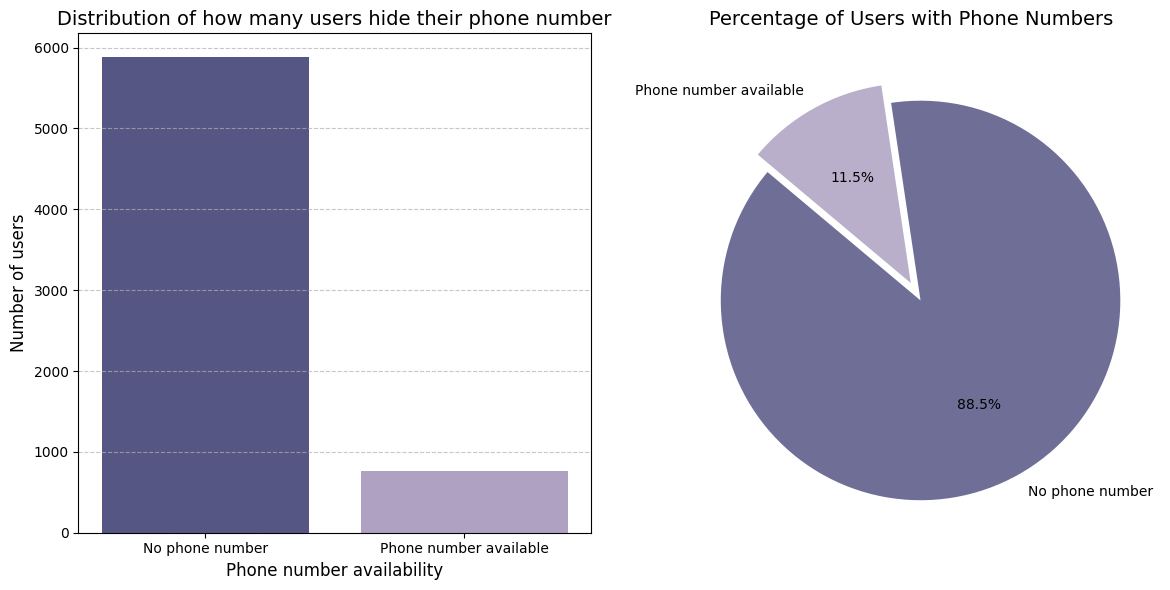

In [ ]:
unique_users = df_users.drop_duplicates(subset=['user_id'])

print(f"Total unique users: {len(unique_users)}")

phone_available = unique_users['phone'].notna().value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

axes[0].bar(
    ['No phone number', 'Phone number available'],
    phone_available,
    color=['#0E0E52', '#8C7AA9'],
    alpha=0.7,
)
axes[0].set_title('Distribution of how many users hide their phone number', fontsize=14)
axes[0].set_xlabel('Phone number availability', fontsize=12)
axes[0].set_ylabel('Number of users', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

labels = ['No phone number', 'Phone number available']
colors = ['#0E0E52', '#8C7AA9']
explode = [0.1, 0]
patches, texts, autotexts = axes[1].pie(
    phone_available,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
)

for patch in patches:
    patch.set_alpha(0.6)

axes[1].set_title('Percentage of Users with Phone Numbers', fontsize=14)

plt.tight_layout()
plt.show()

So from 6650 unique users I have in my records? around 88,5% twnd to hide their phone numbers which is high amound. I think that this is a good tendency in our society, as phone number is a sensitive information.

###5. NLP **analysis**

Let's now investigate the sentiment of my messages and messages sent by other people.



#### All messages

In [ ]:
# filter out non-null(nan) messages for analysis
all_messages = df_merged.dropna(subset=['message']).reset_index(drop=True)

print(len(all_messages))
all_messages.head()

1021225


,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type,hour,day_of_week
0,3807.0,2024-10-24 14:27:52+00:00,<NA>,1073261085,NaN,🎙Радіодиктант національної єдності \n\n25.10.2...,photo,NaN,NaN,-1001073261085,KMA Today,Channel,14,Thursday
1,3806.0,2024-10-24 11:59:58+00:00,<NA>,1073261085,NaN,"🎃 Могилянська історія жахів\n\n26.10.24 (сб), ...",photo,NaN,NaN,-1001073261085,KMA Today,Channel,11,Thursday
2,3805.0,2024-10-24 09:01:47+00:00,<NA>,1073261085,NaN,"🌌 «Пітьма щедра, і терпляча, і завжди перемага...",photo,NaN,NaN,-1001073261085,KMA Today,Channel,9,Thursday
3,3804.0,2024-10-24 07:58:02+00:00,<NA>,1073261085,NaN,🕯 Загальнонаціональна хвилина мовчання за заги...,text,NaN,NaN,-1001073261085,KMA Today,Channel,7,Thursday
4,3803.0,2024-10-23 17:02:01+00:00,<NA>,1073261085,NaN,🕵️‍♂️ Обговорення книги Жоеля Діккера «Правда ...,photo,NaN,NaN,-1001073261085,KMA Today,Channel,17,Wednesday


In [ ]:
# Clean messages from frequently seen links and so on
import re

def clean_message(message):
    if not isinstance(message, str):
        return message

    noise_patterns = r'\b(?:app|gl|g_st|ic|d0|bd|b0|ua|uk|www|https?|com|bit\.ly)\b'
    message = re.sub(noise_patterns, '', message, flags=re.IGNORECASE)
    message = re.sub(r'http\S+|www\S+|bit\.ly\S+', '', message)
    message = re.sub(r"\b(бы|предпочли|вы)\b", "", message)   # some old message I want to filter
    message = re.sub(r'[^a-zA-Zа-яА-ЯіІїЇєЄґҐ\s]', '', message)
    message = re.sub(r'\s+', ' ', message).strip()

    return message

all_messages['message'] = all_messages['message'].apply(clean_message)


In [ ]:
# ukrainian stop words are taken from https://github.com/skupriienko/Ukrainian-Stopwords
stopwords_ua = pd.read_csv("/content/drive/MyDrive/tg-dataset-analysis/data/stopwords_ua.txt", header=None, names=['stopwords'])
stop_words_ua = list(stopwords_ua.stopwords)
print(stop_words_ua[:20])

['а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий', 'абичийого', 'абичийому', 'абичим', 'абичию', 'абичия', 'абичиє', 'абичиєму', 'абичиєю', 'абичиєї', 'абичиї']


In [ ]:
stop_words = set(TfidfVectorizer(stop_words='english').get_stop_words())
stop_words.update(stop_words_ua)
stop_words = set(stop_words)


   Preprocess a single message by:
   
    - Removing punctuation
    - Converting to lowercase
    - Tokenizing
    - Lemmatizing
    - Removing stopwords



In [ ]:
with open('/content/drive/MyDrive/tg-dataset-analysis/data/dict_lemmatized_ua_words.json', 'r', encoding='utf-8') as file:
    lemmatizer_dict = json.load(file)

def preprocess_message(message, stop_words, lemmatizer_dict):
    if pd.isnull(message):
        return []

    message = re.sub(r"[^a-zA-Zа-яА-ЯіІїЇєЄґҐ\s]", "", message.lower())

    tokens = re.findall(r'\w+', message, re.UNICODE)

    filtered_tokens = [token for token in tokens if token not in stop_words]


    lemmatized_tokens = [lemmatizer_dict.get(token, token) for token in filtered_tokens]


    return lemmatized_tokens


In [ ]:
all_messages['tokens'] = all_messages['message'].apply(
    lambda x: preprocess_message(x, stop_words, lemmatizer_dict)
)

In [ ]:
# Now we got our tokens column!

all_messages.head()

,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type,hour,day_of_week,tokens
0,3807.0,2024-10-24 14:27:52+00:00,<NA>,1073261085,NaN,Радіодиктант національної єдності пт Бібліотек...,photo,NaN,NaN,-1001073261085,KMA Today,Channel,14,Thursday,"[радіодиктант, національний, єдності, пт, бібл..."
1,3806.0,2024-10-24 11:59:58+00:00,<NA>,1073261085,NaN,Могилянська історія жахів сб ПiдWall Відбудеть...,photo,NaN,NaN,-1001073261085,KMA Today,Channel,11,Thursday,"[могилянський, історія, жах, сб, пiдwall, відб..."
2,3805.0,2024-10-24 09:01:47+00:00,<NA>,1073261085,NaN,Пітьма щедра і терпляча і завжди перемагає сб ...,photo,NaN,NaN,-1001073261085,KMA Today,Channel,9,Thursday,"[пітьма, щедра, терпляча, перемагати, сб, куль..."
3,3804.0,2024-10-24 07:58:02+00:00,<NA>,1073261085,NaN,Загальнонаціональна хвилина мовчання за загибл...,text,NaN,NaN,-1001073261085,KMA Today,Channel,7,Thursday,"[загальнонаціональна, хвилина, мовчання, загиб..."
4,3803.0,2024-10-23 17:02:01+00:00,<NA>,1073261085,NaN,Обговорення книги Жоеля Діккера Правда про спр...,photo,NaN,NaN,-1001073261085,KMA Today,Channel,17,Wednesday,"[обговорення, книга, жоеля, діккера, правда, с..."


In [ ]:
all_messages_tokens = all_messages['tokens']
all_messages_tokens_joined = all_messages['tokens'].apply(lambda tokens: ' '.join(tokens))

print(all_messages_tokens)
print(all_messages_tokens_joined)

# # I am leaving tokens as they are in message as I will need it for tf-idf and future sentiment to date analysis
# all_messages_tokens = all_messages.apply(preprocess_message)
# all_messages_flat_tokens = [token for tokens in all_messages_tokens for token in tokens]
# all_messages = all_messages_tokens.apply(lambda tokens: " ".join(tokens))

# print(all_messages_tokens[:10])
# all_messages.head()

0          [радіодиктант, національний, єдності, пт, бібл...
1          [могилянський, історія, жах, сб, пiдwall, відб...
2          [пітьма, щедра, терпляча, перемагати, сб, куль...
3          [загальнонаціональна, хвилина, мовчання, загиб...
4          [обговорення, книга, жоеля, діккера, правда, с...
                                 ...                        
1021220                                                   []
1021221                                                   []
1021222                      [привіт, спробувати, допомогти]
1021223                  [зрозуміти, трошки, шарити, робити]
1021224    [привітика, звернутися, питання, індивідуальни...
Name: tokens, Length: 1021225, dtype: object
0          радіодиктант національний єдності пт бібліотек...
1          могилянський історія жах сб пiдwall відбутися ...
2          пітьма щедра терпляча перемагати сб культмотив...
3          загальнонаціональна хвилина мовчання загиблими...
4          обговорення книга жоеля дікке

### Tf-idf analysis, message-specific

***Q12. Most popular words across all messages***

First I want to manually define the tf-idf algorithm and perform it for single message as document.

In [ ]:
# from collections import Counter
# import math

# # Calculate Document Frequency (DF)
# df_counts = Counter()
# for tokens in all_messages['tokens']:
#     unique_tokens = set(tokens)
#     df_counts.update(unique_tokens)

# # Calculate IDF
# total_docs = len(all_messages['tokens'])
# idf_scores = {word: math.log(total_docs / (1 + df)) for word, df in df_counts.items()}

# # Compute TF-IDF for each token in each doc using standard formula
# tf_idf_scores = []
# for tokens in all_messages['tokens']:
#     tf_counts = Counter(tokens)
#     tf_doc_total = sum(tf_counts.values())

#     tf_idf_doc = {token: (tf_counts[token] / tf_doc_total) * idf_scores[token] for token in tf_counts.keys()}
#     tf_idf_scores.append(tf_idf_doc)

# print(tf_idf_scores)
# print(df_counts)

# print(sorted(tf_idf_scores[0].items(), key=lambda x: x[1], reverse=True)[:10])

# print(sorted(df_counts.items(), key=lambda x: x[1], reverse=True)[:10])


Now I want to use built in function for TF-IDF and DF as manually implemented one is computationally expensive due to poor optimization and large set of messages.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tf-idf scores to define most used words across all messages
tfidf_vectorizer = TfidfVectorizer(
    max_features=20,
    lowercase=True,
    token_pattern=r'\b[a-zA-Zа-яА-ЯіїєґІЇЄҐ]{3,}\b'  # keep words with 3+ letters
)

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(all_messages_tokens_joined)
tfidf_scores = tfidf_matrix.toarray()

# get the frequency scores for each word
words = tfidf_vectorizer.get_feature_names_out()
avg_scores = tfidf_scores.mean(axis=0)

tfidf_df = pd.DataFrame({'Word': words, 'Score': avg_scores}).sort_values(by='Score', ascending=False)
top_20 = tfidf_df.head(20)

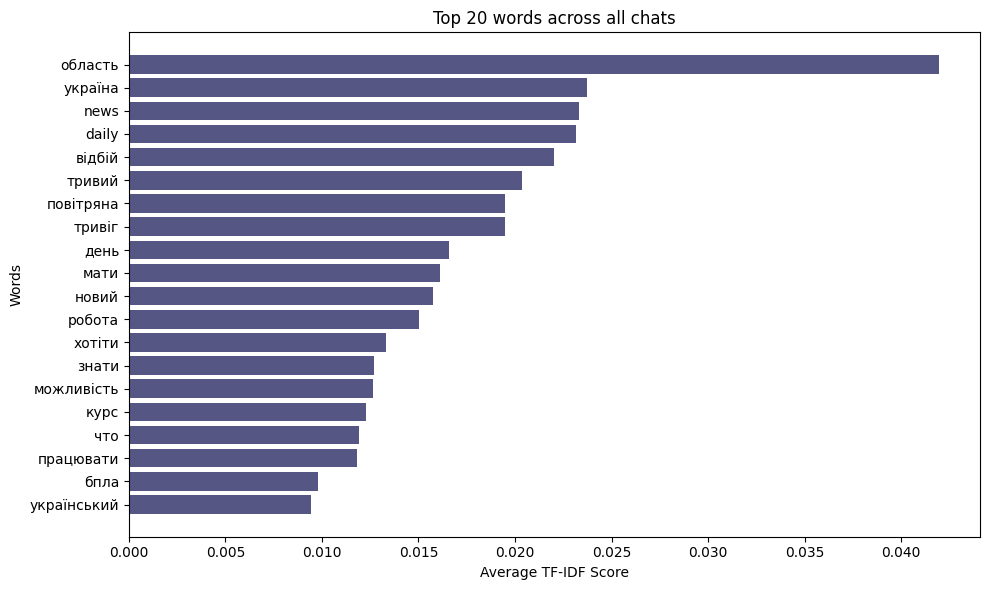

In [ ]:
# Plot the scores
plt.figure(figsize=(10, 6))
plt.barh(top_20['Word'], top_20['Score'], color='#0E0E52', alpha=0.7)
plt.title('Top 20 words across all chats')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

As a result we got:
- here tf-idf would resemble simple document frequency, so we need to find something more interesting

- results are very biased due to air alert channels

- still, this is quite interesting set of words which definetaly capture the state of things that happen in Ukraine (many words related to war topics - область, відбій, тривога, повітряна and etc.)






#### TF-idf. Chat specific

Q13.**Private chats. For chosen chats, define top 5 words**

Judging from 1 word is not really informative, so n-grams would help:)

In [ ]:
# Define some custom stop words which do not really bring sense
custom_stopwords = list({'привіт', 'думати', 'хотіти', 'завтра', 'грн', 'комунальний', 'послуга', 'шо', 'что', 'ти', 'привет', 'есть', 'будь', 'ласка', 'добрий', 'день', 'кононович', 'софія'})

# Top private chats
top_dialog_ids = [396371763, 778227051, 344962616, 778365445, 503066173]

filtered_chats = all_messages[all_messages['dialog_id'].isin(top_dialog_ids)]

# Remove duplicates based on 'dialog_id' and 'dialog_name', ignoring the 'tokens' column
filtered_chats_unique = filtered_chats[['dialog_id', 'dialog_name']].drop_duplicates()

# Concatenate tokens for each unique dialog_id and dialog_name pair
filtered_chats['tokens_joined'] = filtered_chats['tokens'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')
chat_documents = filtered_chats.groupby(['dialog_id', 'dialog_name'])['tokens_joined'].apply(' '.join).reset_index()

tfidf = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords, ngram_range=(2, 3), token_pattern=r'\b[a-zA-Zа-яА-ЯіїєґІЇЄҐ]{3,}\b')  # Bi-grams and tri-grams
tfidf_matrix = tfidf.fit_transform(chat_documents['tokens_joined'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=chat_documents.index)

top_ngrams = {}
for idx, row in chat_documents.iterrows():
    dialog_id = row['dialog_id']
    dialog_name = row['dialog_name']
    top_terms = tfidf_df.loc[idx].sort_values(ascending=False).head(5)
    top_ngrams[dialog_name] = list(top_terms.index)

for dialog_name, ngrams in top_ngrams.items():
    print(f"Top 5 n-grams for chat '{dialog_name}': {', '.join(ngrams)}")

<ipython-input-93-ed914d49f6c9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chats['tokens_joined'] = filtered_chats['tokens'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')


Top 5 n-grams for chat 'Толя❣️': как дело, спокойний ноча, это хорошо, мама казати, главний чтобы
Top 5 n-grams for chat 'Вікуся': окий окий, опа опа, latent factors, стаді румудубрурграр, ура ура
Top 5 n-grams for chat 'Люба': обійм обійм, обійм обійм обійм, комп соушати, комп сошиальсталаслаславаль, laughter events
Top 5 n-grams for chat 'Женя🐣🥰': хоітло спитать, спасибо большой, как делать, вера петровна, скиня пожалуйста
Top 5 n-grams for chat 'Соня Міщенко': data science, чути знати, останній часом, особистий життя, серце болити


That is interesting, as we can see few peculiar phrases which define what I am talking about with my top private messages, and it also can define my relatioship with these people.

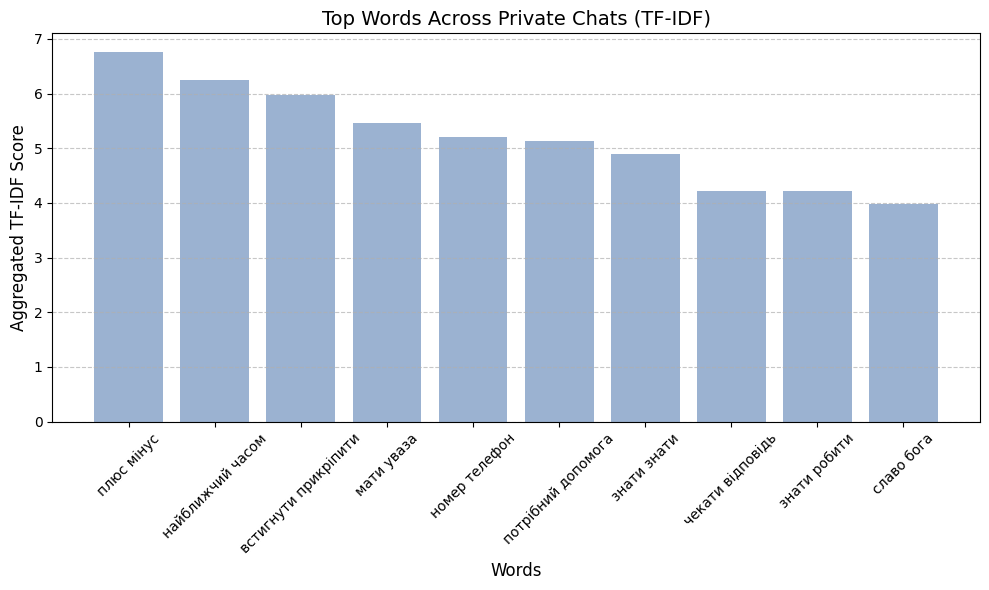

In [ ]:
private_chats = all_messages[all_messages['dialog_type'] == 'Private dialog']

# One private chat is one document
private_chat_documents = private_chats.groupby('dialog_id')['tokens'].apply(
    lambda tokens: ' '.join([' '.join(t) for t in tokens if isinstance(t, list)])
).reset_index()

tfidf = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords, token_pattern=r'\b[a-zA-Zа-яА-ЯіїєґІЇЄҐ]{3,}\b', ngram_range=(2, 3) )
tfidf_matrix = tfidf.fit_transform(private_chat_documents['tokens'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
word_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)

top_words = word_scores.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_words.index, top_words.values, color='#7192BE', alpha=0.7)
plt.title('Top Words Across Private Chats (TF-IDF)', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Aggregated TF-IDF Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 I took bigrams and trigrams here as just taking sincle words tf-idf was not represemntative.

 We see quite interesting pattern for private chats certain daily phrases are very often and I see that 'встигнути прикріпити' indicate that we do talk about studying a lot.

Q14.***What phrases KMA sudents use***

My aim is to analyse the common  phrases which KMA students use, I tried to include all possible KMA chats and channels I have.

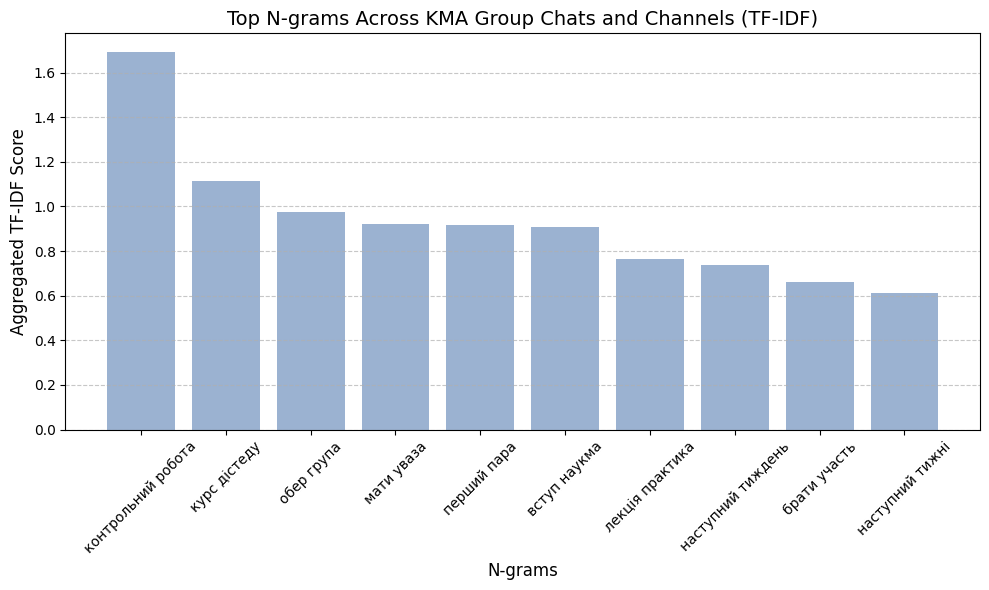

In [ ]:
prefixes = ['МАТЕМАТИКО', 'ФІ', 'ТРОЯ', 'KMA', 'ПМ', 'Труха', 'в(и)хід', 'таких', 'Спудейське']

group_channel_chats = all_messages[
    all_messages['dialog_name'].str.startswith(tuple(prefixes), na=False)
]

# Concatenate tokens for each chat/channel (each dialog_id is a document)
group_channel_documents = group_channel_chats.groupby('dialog_id')['tokens'].apply(
    lambda tokens: ' '.join([' '.join(t) for t in tokens if isinstance(t, list)])
).reset_index()

tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words=custom_stopwords,
    ngram_range=(2, 3),
    token_pattern=r'\b[a-zA-Zа-яА-ЯіїєґІЇЄҐ]{3,}\b')
tfidf_matrix = tfidf.fit_transform(group_channel_documents['tokens'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
ngram_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)

top_ngrams = ngram_scores.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_ngrams.index, top_ngrams.values, color='#7192BE', alpha=0.7)
plt.title('Top N-grams Across KMA Group Chats and Channels (TF-IDF)', fontsize=14)
plt.xlabel('N-grams', fontsize=12)
plt.ylabel('Aggregated TF-IDF Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Q15. N-grams analysis to define most common phrases across all messages

But lets first remove channels which are related with air raid alerts.

Here one documenty is one conversation.


In [ ]:
messages_no_alerts = all_messages[
    ~all_messages['dialog_name'].str.startswith('Карта', na=False)
]

# Define one document as one conversation
conversations = messages_no_alerts.groupby('dialog_id')['tokens'].apply(
    lambda tokens: ' '.join([' '.join(t) for t in tokens if isinstance(t, list)])
).reset_index()

# I have observed some precific words which have no sense so lets exclude them (spam messages)
custom_stopwords = ['inst', 'youtube','реклама', 'lateral', 'текущий', 'размер', 'привіт', 'думати', 'хотіти', 'завтра', 'грн', 'комунальний', 'послуга', 'шо', 'что', 'ти', 'привет', 'есть', 'будь', 'ласка', 'добрий', 'день', 'кононович', 'софія', 'член']
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=20, token_pattern=r'\b[a-zA-Zа-яА-ЯіїєґІЇЄҐ]{3,}\b', stop_words = custom_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(conversations['tokens'])

ngrams = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

tfidf_ngrams_df = pd.DataFrame({'N-Gram': ngrams, 'TF-IDF Score': tfidf_scores}).sort_values(by='TF-IDF Score', ascending=False)

tfidf_ngrams_df_20 = tfidf_ngrams_df.head(20)

print(tfidf_ngrams_df_20)


                       N-Gram  TF-IDF Score
3                взяти участь     55.868289
2            англійський мова     31.989608
6               досвід робота     23.976053
15           повітряна тривий     22.056658
12           надіслати новина     11.993802
16           підтримати канал      3.110420
10            контактнт особа      3.045924
7          замовити надіслати      2.604727
8   замовити надіслати новина      2.604727
1          online безкоштовно      2.114381
0                  daily news      1.634298
11     можливість підписатися      1.139955
9               київський афа      1.001539
17                твой выросо      0.999998
18             територія джун      0.865180
5       джун підтримати канал      0.864434
4             джун підтримати      0.864434
19  територія джун підтримати      0.864434
13        платформа територія      0.856673
14   платформа територія джун      0.856673


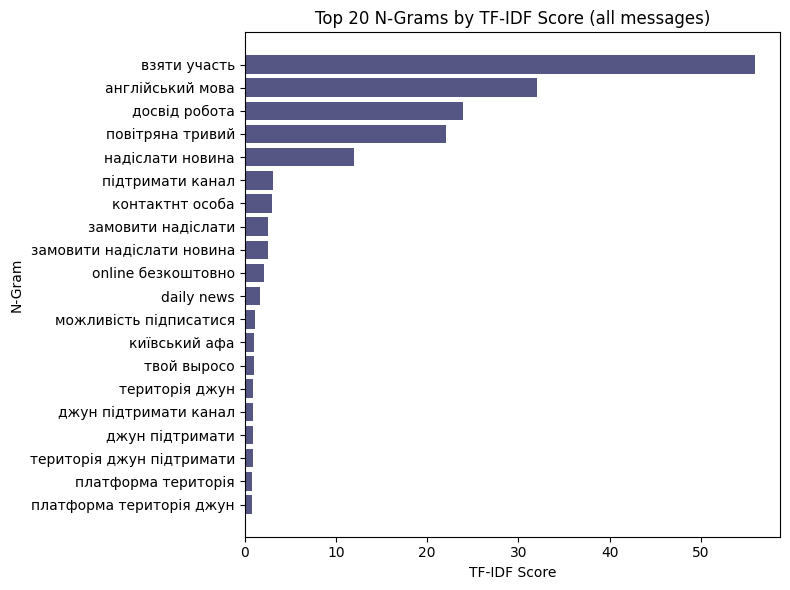

In [ ]:
# Plot the top 20 n-grams
plt.figure(figsize=(8, 6))
plt.barh(tfidf_ngrams_df_20['N-Gram'], tfidf_ngrams_df_20['TF-IDF Score'], color='#0E0E52', alpha=0.7)
plt.xlabel('TF-IDF Score')
plt.ylabel('N-Gram')
plt.title('Top 20 N-Grams by TF-IDF Score (all messages)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Can not really say that results are very interesting, still I have noticed many messages from job seach channels.

### Q16. Investigation of my sentiment

Analyse content sent by me messages and identify frequently used words or topics (something I am most interested in)

**!!Disclaimer!!**

**Results probably contain curse words and phrases and I am sorry for you to read it, but it is my everyday words sometimes and it was interesting for me to find out their frequency in my speech.**

In [ ]:
sent_by_me = all_messages[all_messages['from_id'] == my_id]
sent_by_me_tokens_joined = sent_by_me['tokens'].apply(lambda tokens: ' '.join(tokens))

sent_by_me_tokens_joined.head()

,tokens
27258,бліно сорі перебити потікік думка
27260,шукати розробник компанія hodimo іт стартап по...
100130,привіт команда могилянців активно працювати ст...
132325,оей ділов пропозиція піти пххппх
132332,тисячний підписник річ гарний фото


In [ ]:
tfidf_vectorizer_me = TfidfVectorizer(
    max_features=20,
    lowercase=True,
    token_pattern=r'\b[a-zA-Zа-яА-ЯіїєґІЇЄҐ]{3,}\b'
)

tfidf_matrix_me = tfidf_vectorizer_me.fit_transform(sent_by_me_tokens_joined)
tfidf_scores_me = tfidf_matrix_me.toarray()

words_me = tfidf_vectorizer_me.get_feature_names_out()
avg_scores_me = tfidf_scores_me.mean(axis=0)

tfidf_df_me = pd.DataFrame({'Word': words_me, 'Score': avg_scores_me}).sort_values(by='Score', ascending=False)

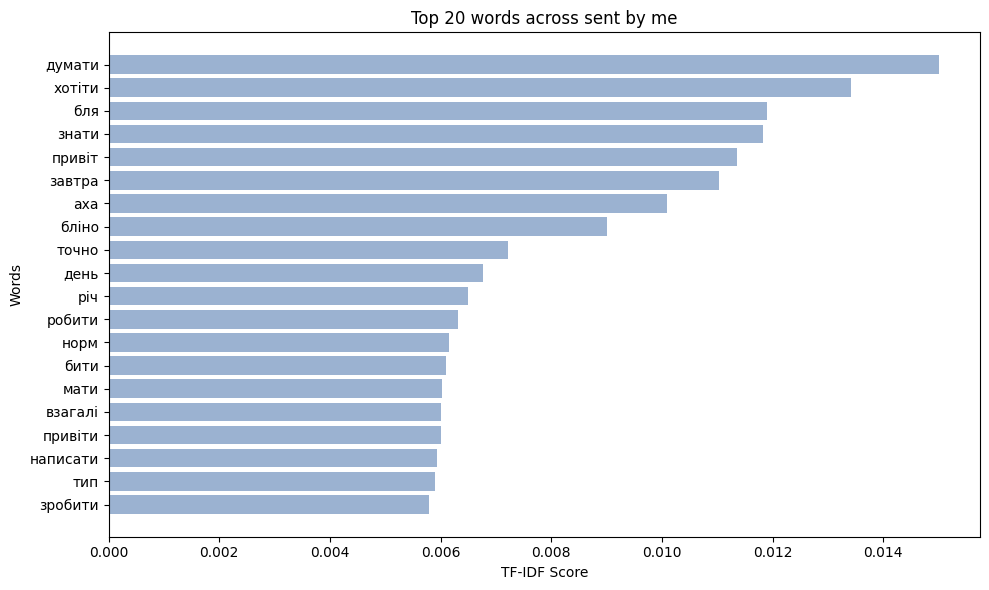

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(tfidf_df_me['Word'], tfidf_df_me['Score'], color='#7192BE', alpha=0.7)
plt.title('Top 20 words across sent by me')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

That is particulary interesting for me, especially that curse word is top 3 words used by me)

 N-grams analysis to define my most common phrases

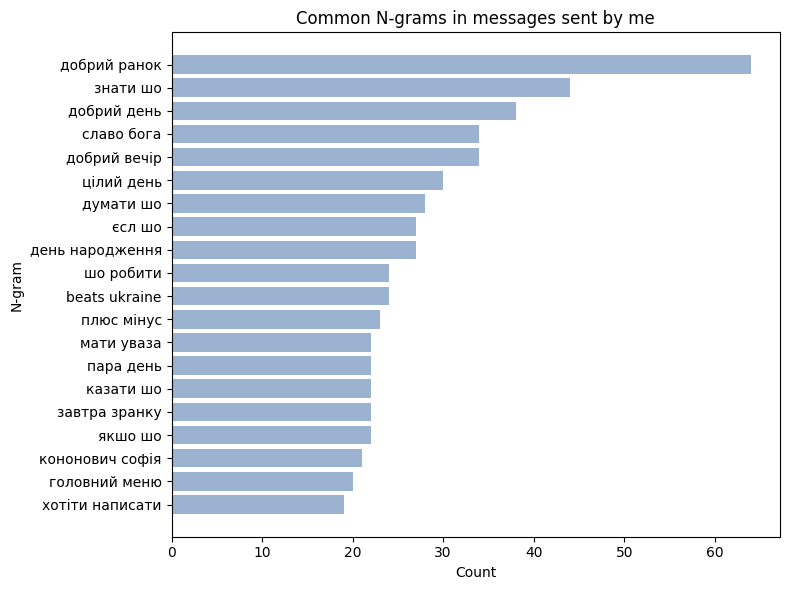

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

my_vectorizer = CountVectorizer(ngram_range=(2,3), max_features=20)

my_ngrams_matrix = my_vectorizer.fit_transform(sent_by_me_tokens_joined)
my_ngrams = my_vectorizer.get_feature_names_out()
my_ngrams_counts = my_ngrams_matrix.sum(axis=0).A1

my_ngrams_df = pd.DataFrame({'N-gram': my_ngrams, 'Count': my_ngrams_counts})
my_ngrams_df = my_ngrams_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(my_ngrams_df['N-gram'], my_ngrams_df['Count'], color='#7192BE', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('N-gram')
plt.title('Common N-grams in messages sent by me')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Sentiment analysis. Review the tone I message with over time (positive, negative, neutral)

#### Sentiment analysis using tone dictionaries https://github.com/SanGreel/tone-dict-ukrainian/blob/master/README.md

In [ ]:
tone_dict_df = pd.read_csv('/content/drive/MyDrive/tg-dataset-analysis/data/tone-dict-uk-full.csv', sep=',', header=0)  # Adjust file path and delimiter if necessary

sentiment_dict = pd.Series(tone_dict_df['sentiment'].values, index=tone_dict_df['word']).to_dict()

In [ ]:
sent_by_me['tokens'].head()

,tokens
27258,"[бліно, сорі, перебити, потікік, думка]"
27260,"[шукати, розробник, компанія, hodimo, іт, стар..."
100130,"[привіт, команда, могилянців, активно, працюва..."
132325,"[оей, ділов, пропозиція, піти, пххппх]"
132332,"[тисячний, підписник, річ, гарний, фото]"


In [ ]:
# Define and apply function to calculate the sentiment for single message
def calculate_sentiment(tokens, sentiment_dict):
  if len(tokens) == 0:
    return 0
  sentiment_sum = sum([sentiment_dict.get(token, 0) for token in tokens])
  return sentiment_sum / len(tokens)

sent_by_me['sentiment'] = sent_by_me['tokens'].apply(calculate_sentiment, sentiment_dict=sentiment_dict)

overall_sentiment = sent_by_me['sentiment'].mean()
print("Overall Sentiment:", overall_sentiment)

sent_by_me.head()

Overall Sentiment: 0.054826994499686865


<ipython-input-108-4168d2db8e9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_by_me['sentiment'] = sent_by_me['tokens'].apply(calculate_sentiment, sentiment_dict=sentiment_dict)


,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type,hour,day_of_week,tokens,sentiment
27258,369183.0,2024-10-01 13:19:48+00:00,784559684,1142723513,NaN,блін сорі перебила твій потік думок,text,NaN,{},-1001142723513,ФІ,Group,13,Tuesday,"[бліно, сорі, перебити, потікік, думка]",-0.177760
27260,369181.0,2024-10-01 13:19:11+00:00,784559684,1142723513,NaN,Шукаємо розробника Компанія HODIMO ІТ стартап ...,text,NaN,{509580698: <telethon.tl.types.ReactionEmoji o...,-1001142723513,ФІ,Group,13,Tuesday,"[шукати, розробник, компанія, hodimo, іт, стар...",0.178538
100130,287260.0,2024-03-11 16:12:03+00:00,784559684,1142723513,NaN,Усім привіт Команда могилянців зараз активно п...,text,NaN,NaN,-1001142723513,ФІ,Group,16,Monday,"[привіт, команда, могилянців, активно, працюва...",0.223960
132325,311236.0,2022-09-11 23:19:23+00:00,784559684,1209215640,NaN,ого оце ділові пропозиції вже пішли пххппх,text,NaN,{705751024: <telethon.tl.types.ReactionEmoji o...,-1001209215640,чат абітури 🔪,Group,23,Sunday,"[оей, ділов, пропозиція, піти, пххппх]",-0.009100
132332,311228.0,2022-09-11 23:16:45+00:00,784559684,1209215640,NaN,я твій тисячний підписник до речі у тебе дуже ...,text,NaN,{},-1001209215640,чат абітури 🔪,Group,23,Sunday,"[тисячний, підписник, річ, гарний, фото]",0.217080


***Perform my sentiment over time analysis***

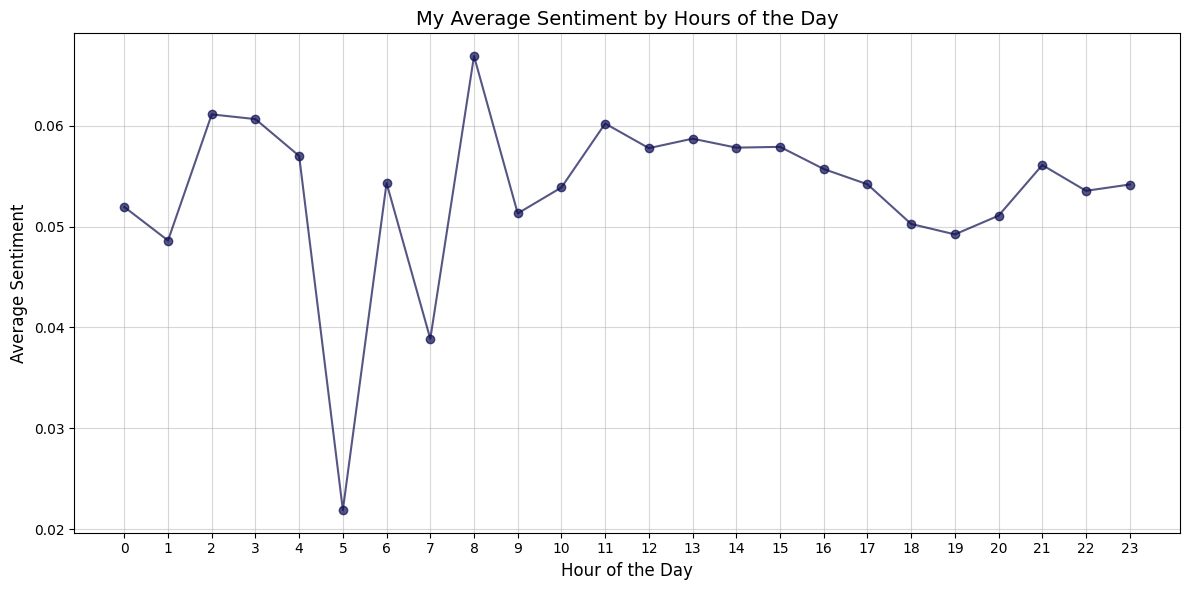

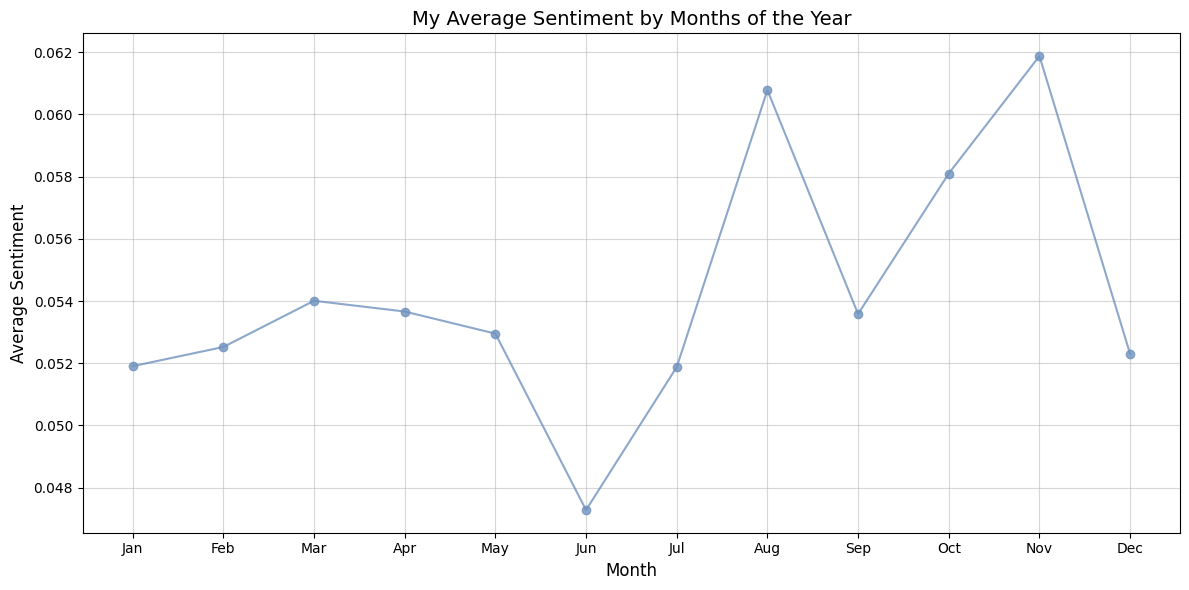

In [ ]:
sentiment_by_hour = sent_by_me.groupby(sent_by_me['date'].dt.hour)['sentiment'].mean().reset_index()
sentiment_by_hour.columns = ['Hour', 'Average Sentiment']

# Plot 1
plt.figure(figsize=(12, 6))
plt.plot(sentiment_by_hour['Hour'], sentiment_by_hour['Average Sentiment'], marker='o', color='#0E0E52', alpha=0.7)
plt.title('My Average Sentiment by Hours of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.grid(True, alpha=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

sentiment_by_month = sent_by_me.groupby(sent_by_me['date'].dt.month)['sentiment'].mean().reset_index()
sentiment_by_month.columns = ['Month', 'Average Sentiment']

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sentiment_by_month['Month'] = sentiment_by_month['Month'].map(lambda x: month_names[x - 1])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sentiment_by_month['Month'], sentiment_by_month['Average Sentiment'], marker='o', color='#7192BE', alpha=0.8)
plt.title('My Average Sentiment by Months of the Year', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


My sentiment is constantly around neutral, however, I can see some paterns depending on the time of the day and month.

Next plot is to understand my variations in the sentiment

         Date  Average Sentiment
0  2019-05-13             0.0000
1  2019-06-15             0.2359
2  2019-08-11             0.0000
3  2019-09-09             0.0000
4  2019-09-19             0.0000


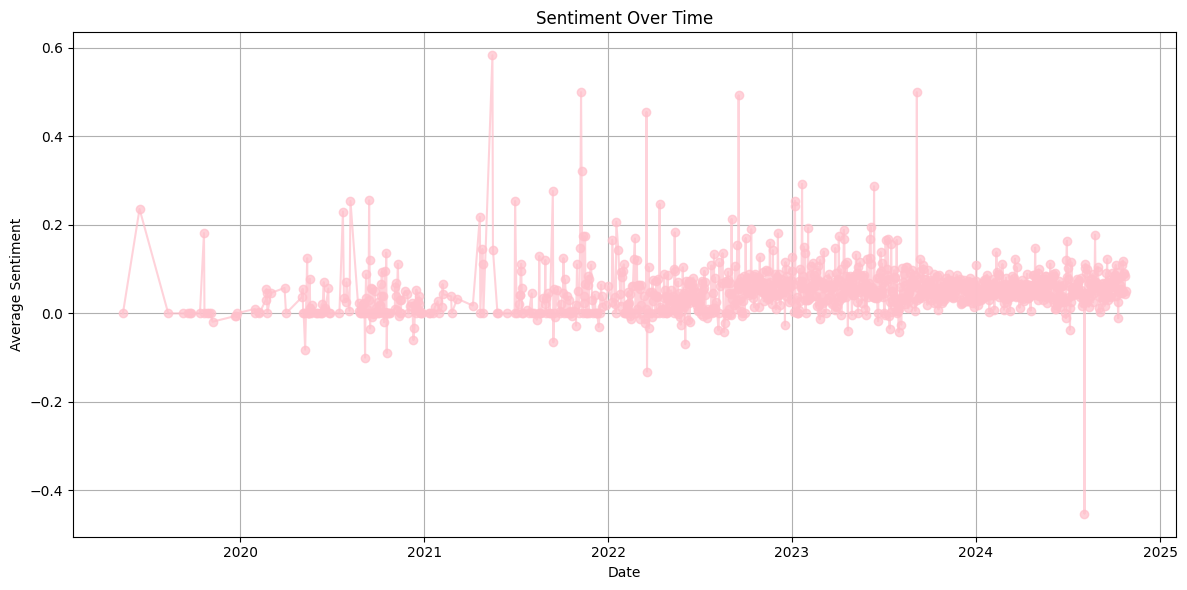

In [ ]:
sentiment_over_time = sent_by_me.groupby(sent_by_me['date'].dt.date)['sentiment'].mean().reset_index()

sentiment_over_time.columns = ['Date', 'Average Sentiment']

print(sentiment_over_time.head())

plt.figure(figsize=(12, 6))
plt.plot(sentiment_over_time['Date'], sentiment_over_time['Average Sentiment'], marker='o', color='pink', alpha=0.7)
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-111-7967b7c7d17e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_by_me['day_of_week'] = sent_by_me['date'].dt.day_name()


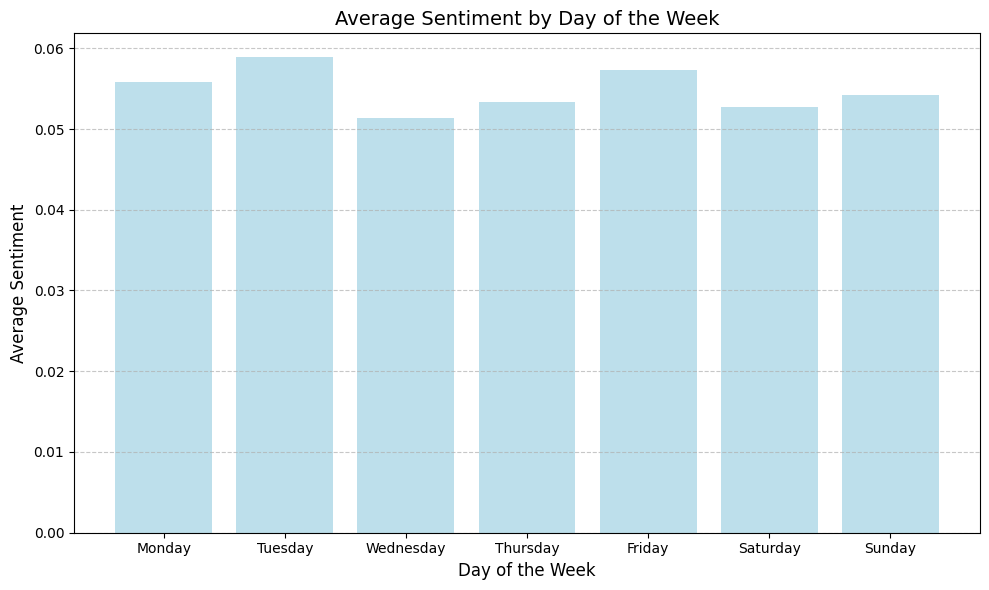

In [ ]:
sent_by_me['day_of_week'] = sent_by_me['date'].dt.day_name()

sentiment_by_day = sent_by_me.groupby('day_of_week')['sentiment'].mean().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sentiment_by_day['day_of_week'] = pd.Categorical(sentiment_by_day['day_of_week'], categories=day_order, ordered=True)
sentiment_by_day = sentiment_by_day.sort_values('day_of_week')

plt.figure(figsize=(10, 6))
plt.bar(sentiment_by_day['day_of_week'], sentiment_by_day['sentiment'], color='lightblue', alpha=0.8)

plt.title('Average Sentiment by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

My sentiment is mainly neautral, however we can see some really good and bad days from sentiment. Also it doesn`not really depend from the day of the week.

Number of positive messages (sentiment > 0,5) and negative (sentiment < -0.5)

<ipython-input-112-2ea9a7c4a04b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_by_me['sentiment_label'] = sent_by_me['sentiment'].apply(classify_sentiment)


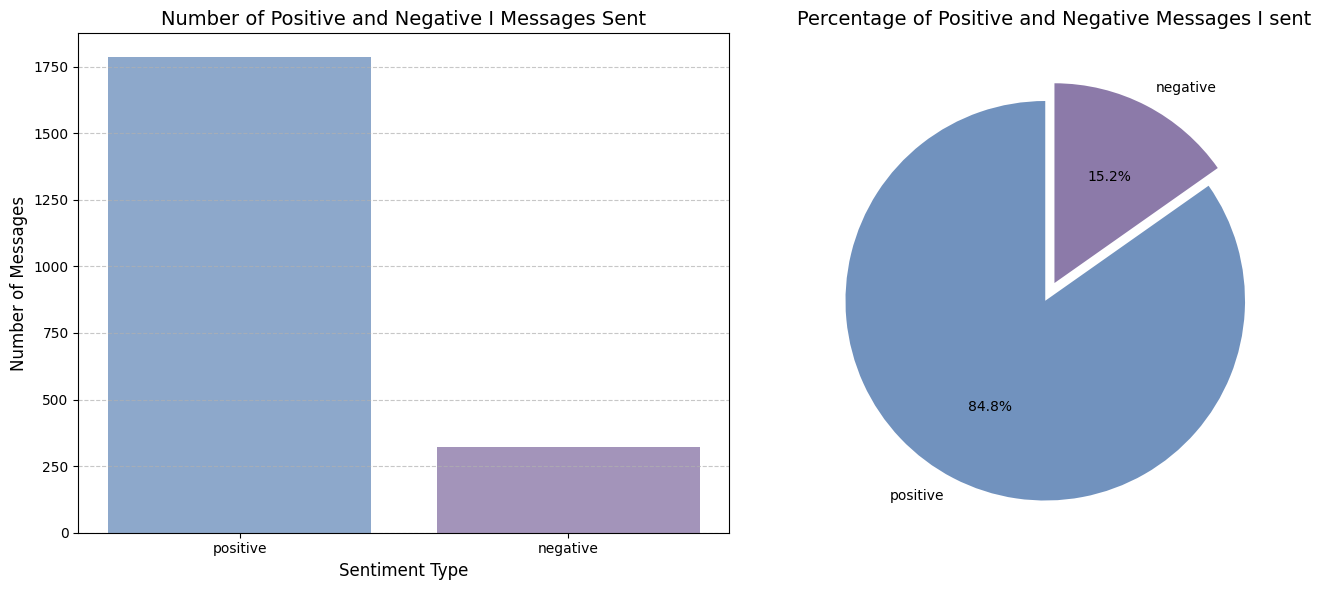

Counts:
 sentiment_label
positive    1786
negative     321
Name: count, dtype: int64

Percentages:
 sentiment_label
positive    84.765069
negative    15.234931
Name: count, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def classify_sentiment(x):
    if x > 0.5:
        return 'positive'
    elif x < -0.5:
        return 'negative'

sent_by_me['sentiment_label'] = sent_by_me['sentiment'].apply(classify_sentiment)

sentiment_counts = sent_by_me['sentiment_label'].value_counts()

sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['#7192BE', '#8C7AA9'], alpha=0.8)
axes[0].set_title('Number of Positive and Negative I Messages Sent', fontsize=14)
axes[0].set_xlabel('Sentiment Type', fontsize=12)
axes[0].set_ylabel('Number of Messages', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].pie(
    sentiment_percentages,
    labels=sentiment_percentages.index,
    autopct='%1.1f%%',
    colors=['#7192BE', '#8C7AA9'],
    startangle=90,
    explode=(0.1, 0)
)
axes[1].set_title('Percentage of Positive and Negative Messages I sent', fontsize=14)

plt.tight_layout()
plt.show()

print("Counts:\n", sentiment_counts)
print("\nPercentages:\n", sentiment_percentages)



Q18. **Is there a correlation between amount of sleep and sentiment?**

<ipython-input-116-b0172b977b61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_by_me['date'] = pd.to_datetime(sent_by_me['date'])


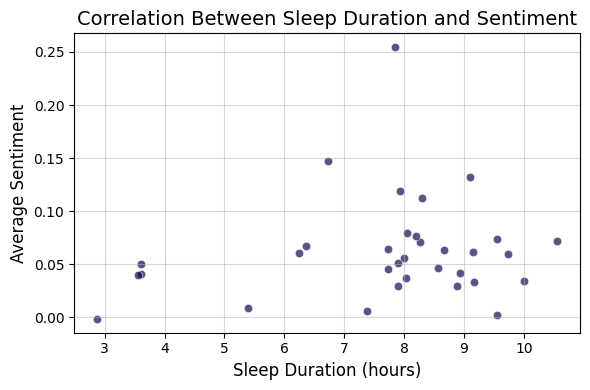

Correlation coefficient between sleep duration and sentiment: 0.17


In [ ]:
df_sleep['date'] = pd.to_datetime(df_sleep['date'])
sent_by_me['date'] = pd.to_datetime(sent_by_me['date'])

# Group sentiment data by date and calculate average sentiment for each day
daily_sentiment = sent_by_me.groupby(sent_by_me['date'].dt.date)['sentiment'].mean().reset_index()
daily_sentiment.columns = ['date', 'average_sentiment']

df_sleep['date'] = df_sleep['date'].dt.date

merged_data = pd.merge(df_sleep, daily_sentiment, on='date', how='inner')

plt.figure(figsize=(6, 4))
sns.scatterplot(x='sleep_duration', y='average_sentiment', data=merged_data, color='#0E0E52', alpha=0.7)
plt.title('Correlation Between Sleep Duration and Sentiment', fontsize=14)
plt.xlabel('Sleep Duration (hours)', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

correlation = merged_data[['sleep_duration', 'average_sentiment']].corr().iloc[0, 1]
print(f"Correlation coefficient between sleep duration and sentiment: {correlation:.2f}")


Correlation between sleeping hours and sentiment of messages is weak (0.17). But the highest sentiment was for sleeping time approx 8 hours which may indicate that it is best sleeping amount for me:)

### Q19. News channels and groups sentiment analysis


In [ ]:
group_messages = all_messages[all_messages['dialog_type'] == 'Group']
group_messages_tokens_joined = sent_by_me['tokens'].apply(lambda tokens: ' '.join(tokens))

channel_messages = all_messages[all_messages['dialog_type'] == 'Channel']

group_messages.head()

,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type,hour,day_of_week,tokens
15599,381734.0,2024-10-24 17:11:23+00:00,441653104,1142723513,NaN,Stonepilot оце хохма,text,NaN,{935940601: <telethon.tl.types.ReactionEmoji o...,-1001142723513,ФІ,Group,17,Thursday,"[stonepilot, хохма]"
15600,381733.0,2024-10-24 17:02:26+00:00,416492602,1142723513,NaN,він тобі злив забиває чи шо,text,NaN,{1926837991: <telethon.tl.types.ReactionEmoji ...,-1001142723513,ФІ,Group,17,Thursday,"[злити, забивати, шо]"
15601,381731.0,2024-10-24 17:01:17+00:00,1926837991,1142723513,NaN,Це те що не стеля,text,NaN,{},-1001142723513,ФІ,Group,17,Thursday,[стеляль]
15602,381730.0,2024-10-24 17:00:35+00:00,416492602,1142723513,NaN,що таке підлога,text,NaN,{1926837991: <telethon.tl.types.ReactionEmoji ...,-1001142723513,ФІ,Group,17,Thursday,[підлога]
15603,381729.0,2024-10-24 16:57:22+00:00,425860006,1142723513,NaN,Народ проголосуйте за другий варіант дуже вдячний,text,NaN,{},-1001142723513,ФІ,Group,16,Thursday,"[народ, проголос, варіант, вдячний]"


In [ ]:
for df in [group_messages, channel_messages]:
    df['sentiment'] = df['tokens'].apply(calculate_sentiment, sentiment_dict=sentiment_dict)

target_groups = ['ФІ', 'МАТЕМАТИКОПРИКЛАДСТВО', 'London', 'ТРОЯ', 'всім']
target_channels = ['Лачен', 'STERNENKO', 'Повітря', 'Карта']

filtered_group_messages = group_messages[
    group_messages['dialog_name'].str.contains('|'.join(target_groups), na=False)
]
filtered_channel_messages = channel_messages[
    channel_messages['dialog_name'].str.contains('|'.join(target_channels), na=False)
]

group_avg_sentiment = filtered_group_messages.groupby('dialog_name')['sentiment'].mean().reset_index()
channel_avg_sentiment = filtered_channel_messages.groupby('dialog_name')['sentiment'].mean().reset_index()

channel_avg_sentiment


<ipython-input-119-a52614f121e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['tokens'].apply(calculate_sentiment, sentiment_dict=sentiment_dict)
<ipython-input-119-a52614f121e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['tokens'].apply(calculate_sentiment, sentiment_dict=sentiment_dict)


,dialog_name,sentiment
0,STERNENKO,0.039252
1,Карта повітряних тривог 🇺🇦,0.010181
2,Лачен пише,0.043083


<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from current font.
  plt.tight_layout()
<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 128133 (\N{NAIL POLISH}) missing from current font.
  plt.tight_layout()
<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  plt.tight_layout()
<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 128001 (\N{MOUSE}) missing from current font.
  plt.tight_layout()
<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from current font.
  plt.tight_layout()
<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  plt.tight_layout()
<ipython-input-120-9b41345d0128>:12: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dis

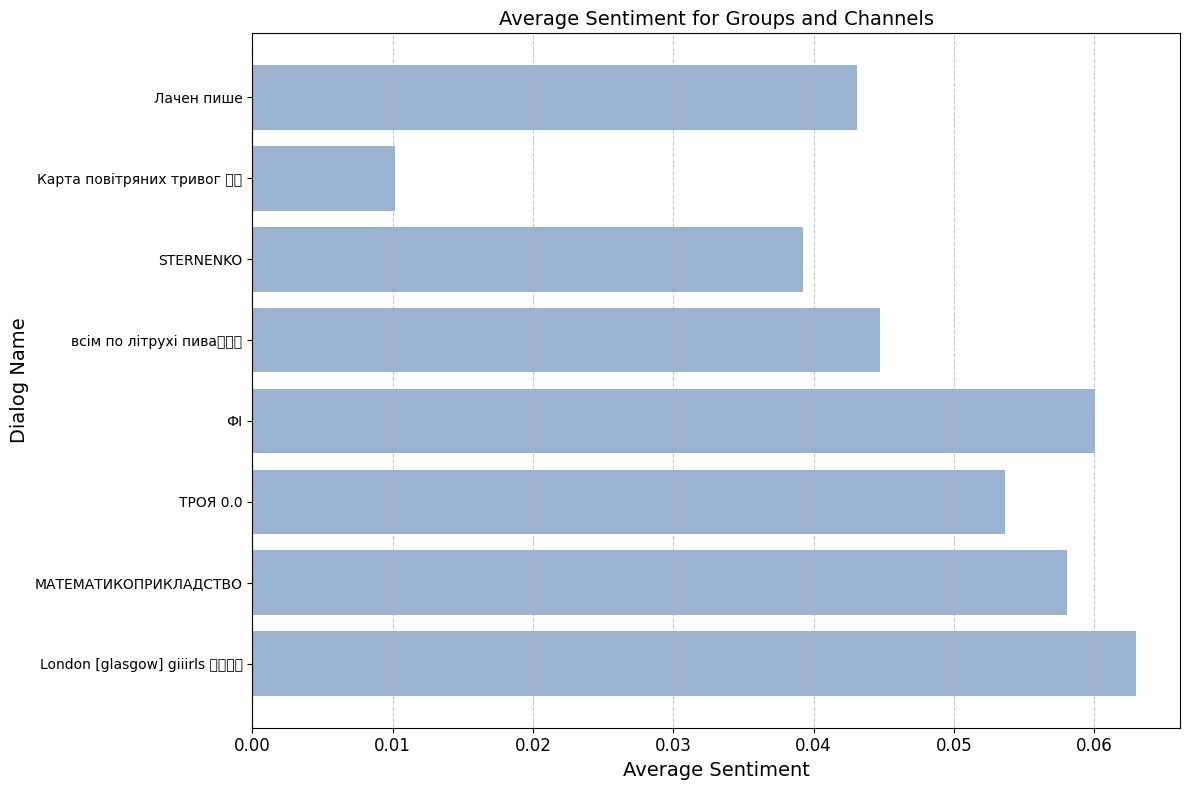

In [ ]:
combined_sentiments = pd.concat([group_avg_sentiment, channel_avg_sentiment])

plt.figure(figsize=(12, 8))
plt.barh(combined_sentiments['dialog_name'], combined_sentiments['sentiment'], color='#7192BE', alpha=0.7)
plt.title('Average Sentiment for Groups and Channels', fontsize=14)
plt.xlabel('Average Sentiment', fontsize=14)
plt.ylabel('Dialog Name', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


Sentiment over news chanells and groups is mainly neutral I can say.

News channel Лачен пише sentiment over day

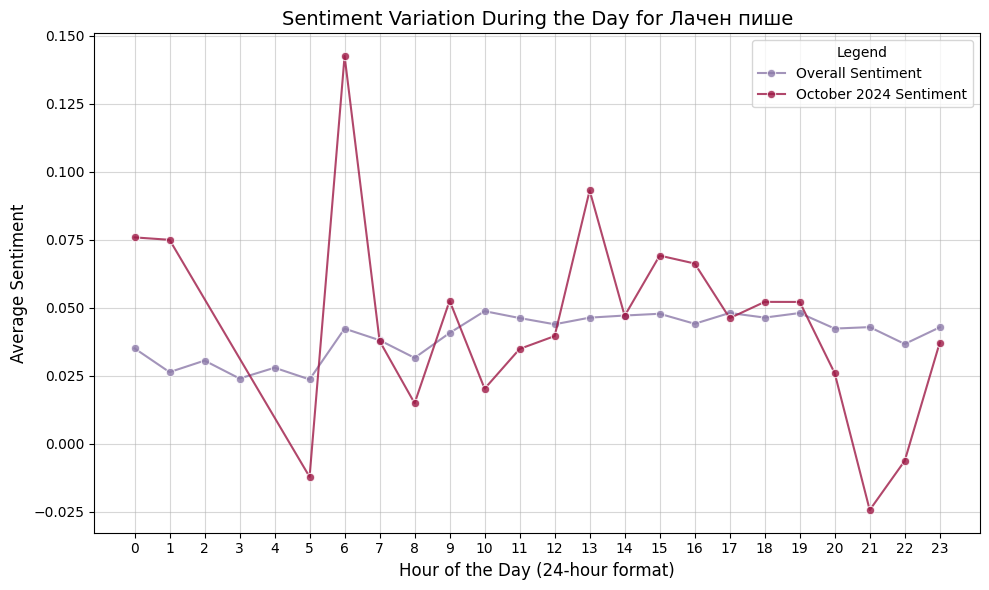

In [ ]:
lachen_messages = channel_messages[channel_messages['dialog_name'] == 'Лачен пише']
sentiment_by_hour = lachen_messages.groupby('hour')['sentiment'].mean().reset_index()

lachen_messages_october = channel_messages[
    (channel_messages['dialog_name'] == 'Лачен пише') &
    (channel_messages['date'].dt.year == 2024) &
    (channel_messages['date'].dt.month == 10)
]
sentiment_by_hour_october = lachen_messages_october.groupby('hour')['sentiment'].mean().reset_index()

plt.figure(figsize=(10, 6))

# Line for overall sentiment
sns.lineplot(
    x='hour', y='sentiment', data=sentiment_by_hour,
    marker='o', color='#8C7AA9', alpha=0.8, label='Overall Sentiment'
)

# Line for October 2024 sentiment
sns.lineplot(
    x='hour', y='sentiment', data=sentiment_by_hour_october,
    marker='o', color='#9E1946', alpha=0.8, label='October 2024 Sentiment'
)

plt.title('Sentiment Variation During the Day for Лачен пише', fontsize=14)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.xticks(range(0, 24))  # Ensure all hours are shown on the X-axis
plt.legend(title='Legend', fontsize=10)
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

Though sentiments are concentrated around neatral, lets stick up to this 'little' variations on plot and thus make conclusions that for the night time news are more negative(air raid alarms, shelling are usually at night time)

]


#### Q20. Students of Comp Science Majors vs Other majors sentiment

Here lets analyse the sentiment of students in Faculty of informatics chat and chats where other majors do talk (chat of the dorm)

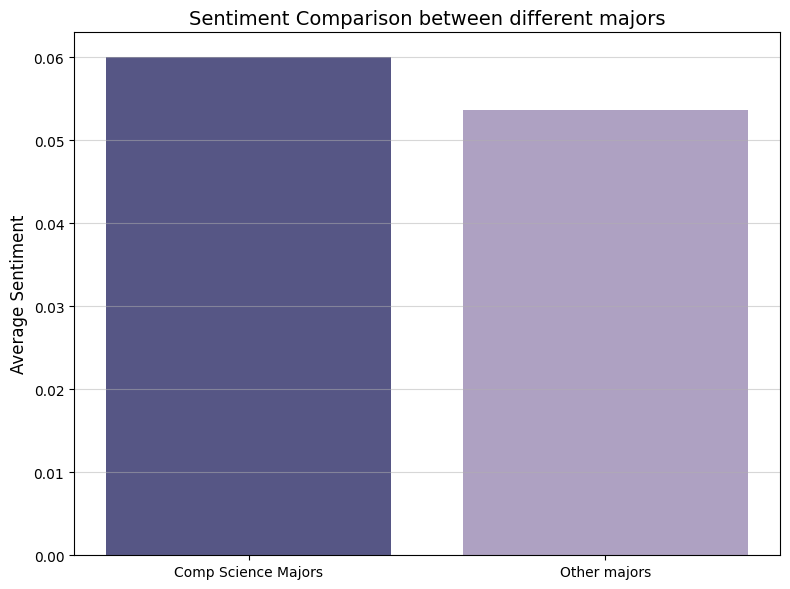

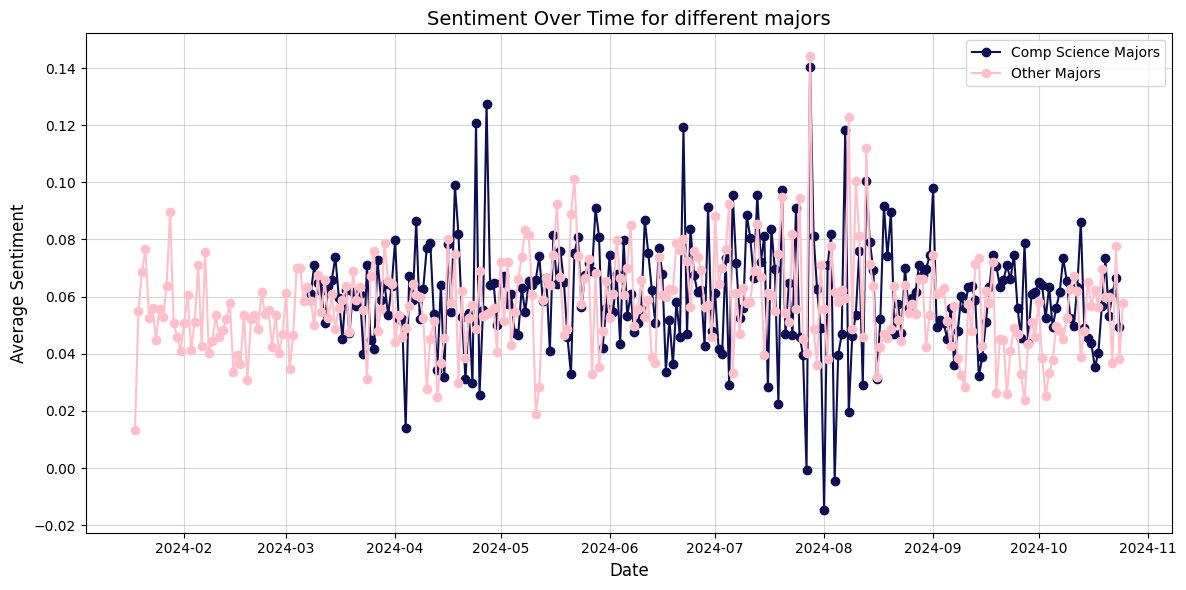

In [ ]:
# Filter chats with names starting with "ФІ" or "ТРОЯ"
selected_chats = group_messages[
    group_messages['dialog_name'].str.startswith(('ФІ', 'ТРОЯ'), na=False)
]

selected_chats = selected_chats[['dialog_name', 'date', 'sentiment']].dropna()

fi_chat = selected_chats[selected_chats['dialog_name'].str.startswith('ФІ')]
troya_chat = selected_chats[selected_chats['dialog_name'].str.startswith('ТРОЯ')]

fi_avg_sentiment = fi_chat['sentiment'].mean()
troya_avg_sentiment = troya_chat['sentiment'].mean()

# Sentiment over time (group by date and calculate mean sentiment)
fi_sentiment_over_time = fi_chat.groupby(fi_chat['date'].dt.date)['sentiment'].mean().reset_index()
troya_sentiment_over_time = troya_chat.groupby(troya_chat['date'].dt.date)['sentiment'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(['Comp Science Majors', 'Other majors'], [fi_avg_sentiment, troya_avg_sentiment], color=['#0E0E52', '#8C7AA9'], alpha=0.7)
plt.title('Sentiment Comparison between different majors', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(fi_sentiment_over_time['date'], fi_sentiment_over_time['sentiment'], label='Comp Science Majors', marker='o', color='#0E0E52')
plt.plot(troya_sentiment_over_time['date'], troya_sentiment_over_time['sentiment'], label='Other Majors', marker='o', color='pink')
plt.title('Sentiment Over Time for different majors', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



Number of positive messages (sentiment > 0,5) and negative (sentiment < -0.5)


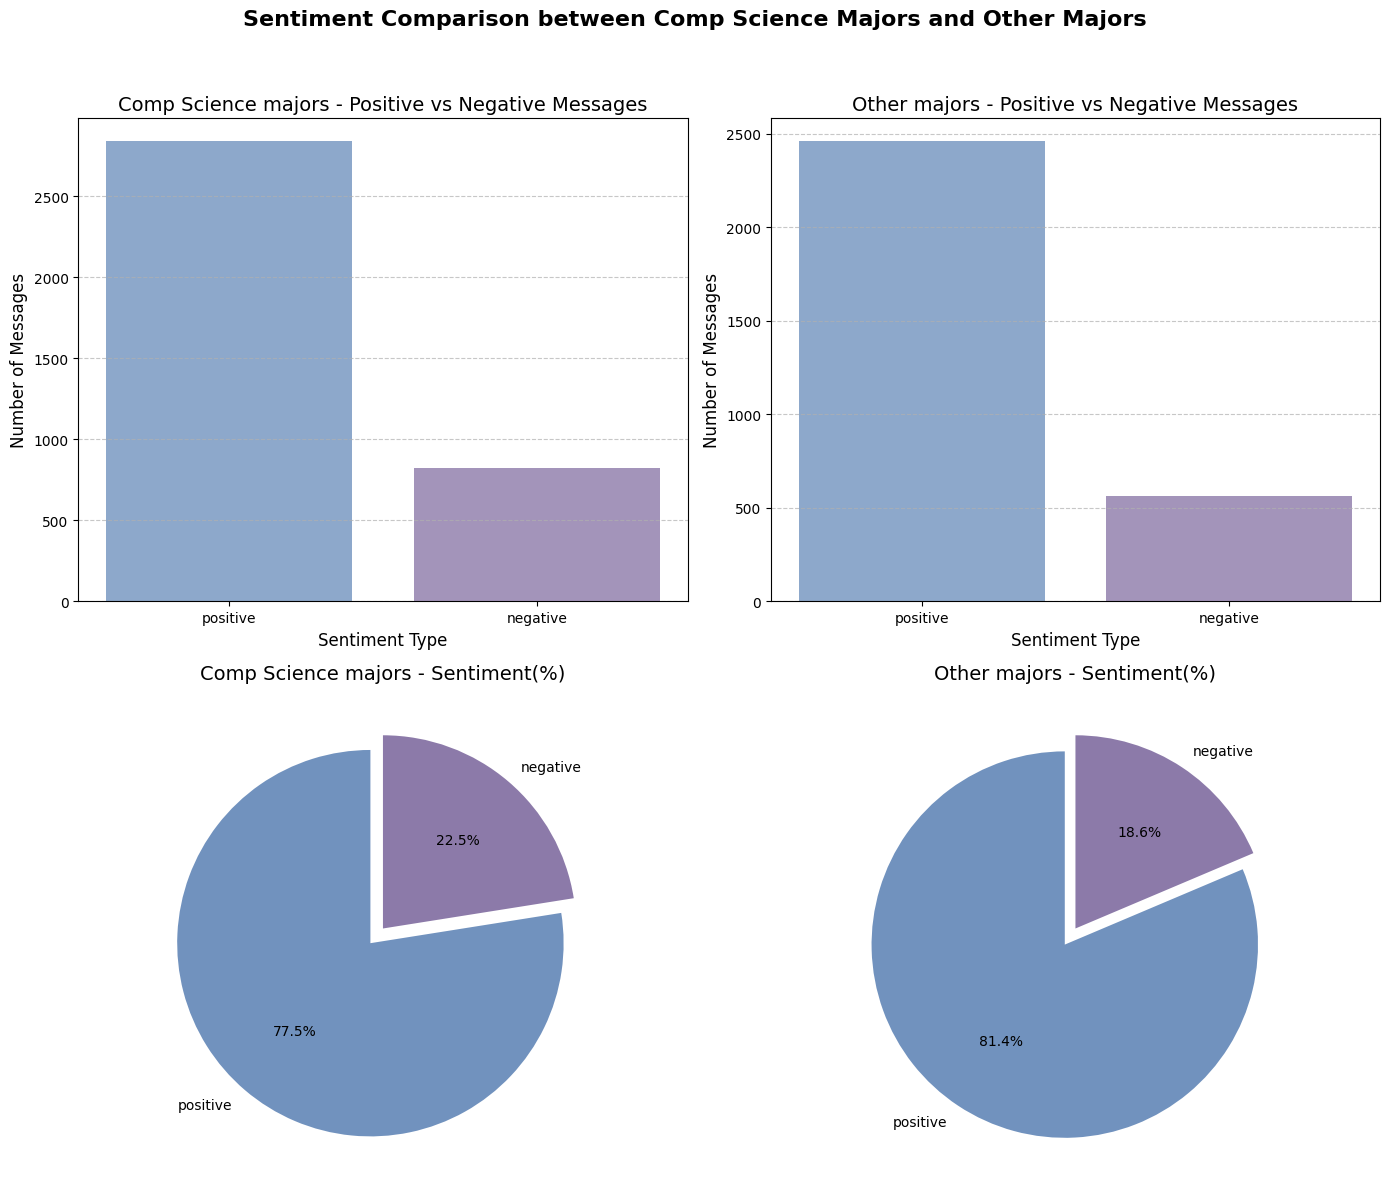

In [ ]:
# Classify messages as positive (>0.5) or negative (<0.5)
selected_chats = group_messages[
    group_messages['dialog_name'].str.startswith(('ФІ', 'ТРОЯ'), na=False)
]

selected_chats = selected_chats[['dialog_name', 'date', 'sentiment']].dropna()

def classify_sentiment(x):
    if x > 0.5:
        return 'positive'
    elif x < -0.5:
        return 'negative'

selected_chats['sentiment_label'] = selected_chats['sentiment'].apply(classify_sentiment)

fi_chat = selected_chats[selected_chats['dialog_name'].str.startswith('ФІ')]
troya_chat = selected_chats[selected_chats['dialog_name'].str.startswith('ТРОЯ')]

fi_sentiment_counts = fi_chat['sentiment_label'].value_counts()
troya_sentiment_counts = troya_chat['sentiment_label'].value_counts()

sentiment_comparison = pd.DataFrame({
    'ФІ': fi_sentiment_counts,
    'ТРОЯ': troya_sentiment_counts
}).fillna(0)
sentiment_comparison = sentiment_comparison.T

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].bar(sentiment_comparison.columns, sentiment_comparison.loc['ФІ'], color=['#7192BE', '#8C7AA9'], alpha=0.8)
axes[0, 0].set_title('Comp Science majors - Positive vs Negative Messages', fontsize=14)
axes[0, 0].set_xlabel('Sentiment Type', fontsize=12)
axes[0, 0].set_ylabel('Number of Messages', fontsize=12)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

axes[0, 1].bar(sentiment_comparison.columns, sentiment_comparison.loc['ТРОЯ'], color=['#7192BE', '#8C7AA9'], alpha=0.8)
axes[0, 1].set_title('Other majors - Positive vs Negative Messages', fontsize=14)
axes[0, 1].set_xlabel('Sentiment Type', fontsize=12)
axes[0, 1].set_ylabel('Number of Messages', fontsize=12)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

fi_percentages = (fi_sentiment_counts / fi_sentiment_counts.sum()) * 100
axes[1, 0].pie(
    fi_percentages,
    labels=fi_percentages.index,
    autopct='%1.1f%%',
    colors=['#7192BE', '#8C7AA9'],
    startangle=90,
    explode=(0.1, 0)
)
axes[1, 0].set_title('Comp Science majors - Sentiment(%)', fontsize=14)

troya_percentages = (troya_sentiment_counts / troya_sentiment_counts.sum()) * 100
axes[1, 1].pie(
    troya_percentages,
    labels=troya_percentages.index,
    autopct='%1.1f%%',
    colors=['#7192BE', '#8C7AA9'],
    startangle=90,
    explode=(0.1, 0)
)
axes[1, 1].set_title('Other majors - Sentiment(%)', fontsize=14)

fig.suptitle('Sentiment Comparison between Comp Science Majors and Other Majors', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

From plots we can judje that computer science students have 3,9% more negative messages(in compare with positives) comparing to other majors.

### 5. Gender behavioural analysis research (Q21)
**Introduction**

I once performed a little research https://docs.google.com/document/d/1vBfcM-wtRUis_z5S-cQhafv_-RTxhOPw/edit?usp=sharing&ouid=103016955909408247864&rtpof=true&sd=true on real data which rejected the Null Hypothesis below.  We observed the laughter events in phone calls depending on gender.

I want to test Research Hypothesis but now on Laughter events from telegram messages. I will take only one group chat with my Applied Mathematics groupmates and look for availability of lauther patters in each message.

**Research Hypothesis:**
H1: The number of laughter events higher for women than for men.

**Null Hypothesis:**
H0: There is no difference in the number of laughter events depending on gender of texter.


Plan:
- divide people from group chat onto male/female categories
- take equal number of messages sent by male/female
- search for patterns like 'ахахаха', 'лол', 'ахпхпх' and so on
- analise the sentiment of bothcategories
- make conclusions



In [ ]:
# Import labeled users data for specific chat
test_chat_users = pd.read_csv("/content/drive/MyDrive/tg-dataset-analysis/data/merged_data/test_hypothesis_data.csv")

In [ ]:
test_chat_users.head()

,user_id,first_name,last_name,username,phone,gender
0,966498025,Олександра,NaN,shiracatsiia,NaN,f
1,424531546,катя нич,NaN,trblclf,NaN,f
2,858608240,Аліна,Ємець,Ragulil,NaN,f
3,645926180,Context,NaN,always_another,NaN,m
4,551807138,Максим,NaN,Mr_Boombastick,NaN,m


In [ ]:
from scipy.stats import ttest_ind

# Merge with user data
group_messages = df_merged[df_merged['dialog_name'] == 'МАТЕМАТИКОПРИКЛАДСТВО']
group_messages = group_messages.merge(test_chat_users, left_on='from_id', right_on='user_id', how='left')

# Categorize users by gender
male_messages = group_messages[group_messages['gender'] == 'm']
female_messages = group_messages[group_messages['gender'] == 'f']

female_messages.head()

,id,date,from_id,to_id,fwd_from,message,type,duration,reactions,dialog_id,dialog_name,dialog_type,hour,day_of_week,user_id,first_name,last_name,username,phone,gender
0,95575.0,2024-10-25 10:39:49+00:00,509580698,1671254477,NaN,звучить по діловому,text,NaN,{},-1001671254477,МАТЕМАТИКОПРИКЛАДСТВО,Group,10,Friday,509580698.0,Оленка 🐒,NaN,siklenchak,NaN,f
1,95574.0,2024-10-25 10:39:19+00:00,858608240,1671254477,NaN,Якщо не встигнете будете на катедру йти до Каш...,text,NaN,{},-1001671254477,МАТЕМАТИКОПРИКЛАДСТВО,Group,10,Friday,858608240.0,Аліна,Ємець,Ragulil,NaN,f
2,95573.0,2024-10-25 10:38:10+00:00,858608240,1671254477,NaN,Біжіть забирати речі,text,NaN,{},-1001671254477,МАТЕМАТИКОПРИКЛАДСТВО,Group,10,Friday,858608240.0,Аліна,Ємець,Ragulil,NaN,f
3,95572.0,2024-10-25 10:38:05+00:00,858608240,1671254477,NaN,"Поки триндим з дідом, але він виганяє",text,NaN,{620607419: <telethon.tl.types.ReactionEmoji o...,-1001671254477,МАТЕМАТИКОПРИКЛАДСТВО,Group,10,Friday,858608240.0,Аліна,Ємець,Ragulil,NaN,f
7,95568.0,2024-10-25 09:05:37+00:00,509580698,1671254477,NaN,тільки це Кашп,text,NaN,{},-1001671254477,МАТЕМАТИКОПРИКЛАДСТВО,Group,9,Friday,509580698.0,Оленка 🐒,NaN,siklenchak,NaN,f


In [ ]:
# Equal Sampling
sample_size = min(len(male_messages), len(female_messages))
male_sample = male_messages.sample(sample_size, random_state=42)
female_sample = female_messages.sample(sample_size, random_state=42)

print('The length of each sample is', len(male_sample), 'messages')

The length of each sample is 11814 messages


In [ ]:
# Function to detect laughter patterns (I tried to do it universal)

def count_laughter_patterns(text):
    laughter_pattern = (
        r'\b(ах+|ахах+|хаха+|ахпх+|пхпх+|хех+|азаз+|взаха+|сміюсь+|смішно+|лол+|hehe+|haha+)\b|'  # Words like ахахаха, хаха, хех
        r'[😂🤣😀]'
    )
    return len(re.findall(laughter_pattern, text.lower())) if isinstance(text, str) else 0

In [ ]:
male_sample['laughter_count'] = male_sample['message'].apply(count_laughter_patterns)
female_sample['laughter_count'] = female_sample['message'].apply(count_laughter_patterns)

f_laughs = female_sample[female_sample['laughter_count'] == 1]

female_sample['laughter_count'].head()

,laughter_count
12455,0
24147,0
3381,0
5142,0
17245,0


Next I use libraries for statistical tests as I want to save some time.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
# Statistical Testing : Decided to choose Z-test for our data

# Count laughter events
male_positive = (male_sample['laughter_count'] > 0).sum()
female_positive = (female_sample['laughter_count'] > 0).sum()

# Total messages
male_total = len(male_sample)
female_total = len(female_sample)

# Proportions Z-Test
count = [male_positive, female_positive]
nobs = [male_total, female_total]

z_stat, p_value = proportions_ztest(count, nobs)
print(f"Z-Test Statistic: {z_stat}, P-value: {p_value}")


Z-Test Statistic: 2.5366270542578992, P-value: 0.011192611988278759


Lets come up with alternative hypothesis :

**Alternative Hypothesis (H1): **A significant difference in the proportion of laughter events exists.** **

The value of p is below 0.05, so **we reject the null hypothesis with 95% confidence.**

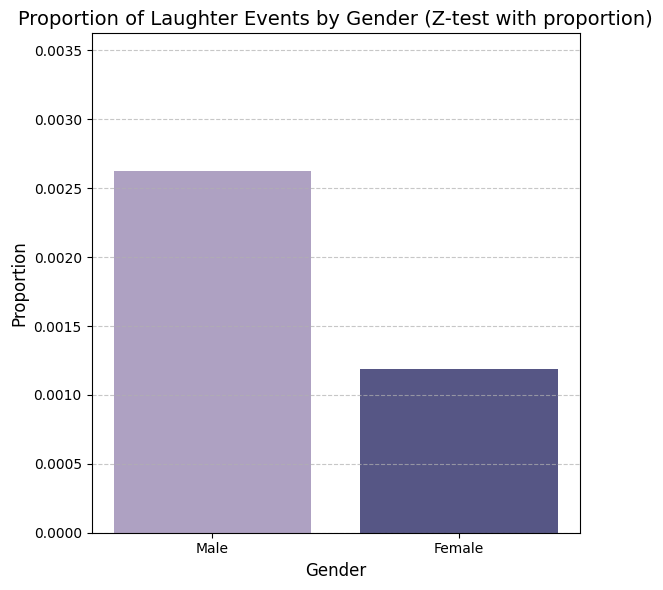

In [ ]:
import matplotlib.pyplot as plt

male_proportion = male_positive / male_total
female_proportion = female_positive / female_total

plt.figure(figsize=(6, 6))
plt.bar(['Male', 'Female'], [male_proportion, female_proportion], color=['#8C7AA9', '#0E0E52'], alpha=0.7)
plt.title('Proportion of Laughter Events by Gender (Z-test with proportion)', fontsize=14)
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('Gender', fontsize=12)

plt.ylim(0, max(male_proportion, female_proportion)+0.001)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

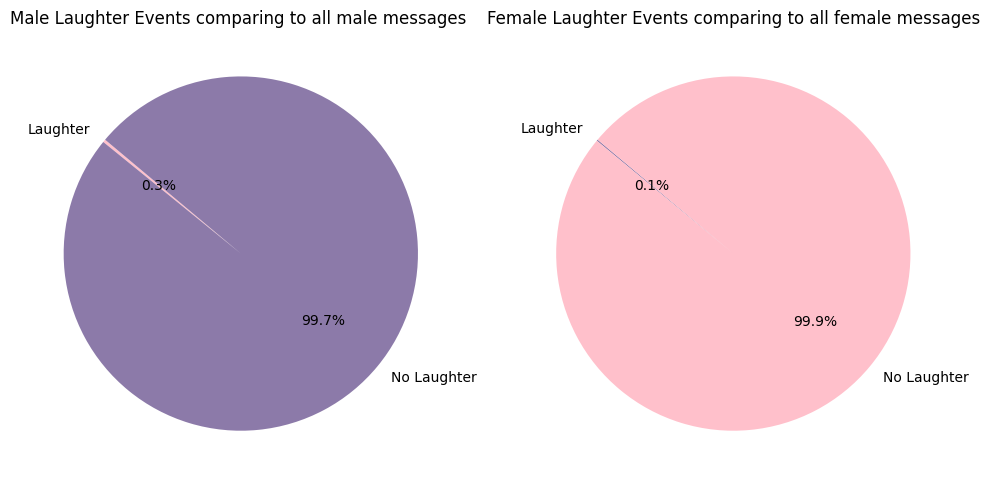

In [ ]:
male_labels = ['Laughter', 'No Laughter']
male_sizes = [male_positive, male_total - male_positive]

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.pie(male_sizes, labels=male_labels, autopct='%1.1f%%', startangle=140, colors=['pink', '#8C7AA9'])
plt.title('Male Laughter Events comparing to all male messages ')

female_labels = ['Laughter', 'No Laughter']
female_sizes = [female_positive, female_total - female_positive]

plt.subplot(1, 2, 2)
plt.pie(female_sizes, labels=female_labels, autopct='%1.1f%%', startangle=140, colors=['#8C7AA9', 'pink'])
plt.title('Female Laughter Events comparing to all female messages')

plt.tight_layout()
plt.show()

#### Conclusions for statistical test

To my surprise, results of laughter events in messages differ from results in phone calls I observed earlier, we still reject the null hypothesis, stating that **there is relation between laughter events and gender**.

However, the number of laughter events is higher for male subjects to a statistically significant extent.

The possible reasons:

- Expression Style: In some cultures or social groups, males may use humor or laughter as a social bonding mechanism more often than females.

- Gender Norms: Social norms might encourage males to express amusement or joke more explicitly in group settings.

However, I would advise (myself) to try using different statistical tests to minimize the eroor.



## Conclusions

It was truly intersting to work with such data as telegram messages dataset and I certainly drew some insights from it.

- Firstly, it is important to text responsibly and care for what you speak as it is your digital footstep.

- Secondly, the information about your texting activity can show very much about you - your interests, worries, hobbies, words you usually use in daily life.

- Basically, the world has become so digitilised so that **we are what, how and whom we text**.

- There is a bunch of different interesting conclusions in the sentiment analysis

**I have notated intermidiate conclusions almost everywhere, so one big conclusion will be made in the presentation as I need more time to think about it.**

